In [1]:
import pandas as pd
import random
from pydataquery import DataQuery
from matplotlib.colors import LinearSegmentedColormap
from xbbg import blp
import numpy as np
import pytz
import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import scipy.stats as stats
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sympy as sp
import itertools
import warnings
import openpyxl
import subprocess
import dataframe_image as dfi
import time
import pyautogui
import pygetwindow as gw
import pyodbc
import ast
warnings.filterwarnings("ignore")

In [2]:
try:
    df_original = pd.read_parquet("Markit CDS.parquet/")
    
    to_date = datetime.today().date()
    from_date = df_original["close_date"].iloc[-1].date()
    
    from_date_str = from_date.strftime('%m/%d/%Y')
    to_date_str = to_date.strftime('%m/%d/%Y')
    
    conn_str = (
        f'DRIVER={{SQL Server}};'
        f'SERVER=BC-ODS-P1;'
        f'DATABASE=MarkitDB;'
        f'ApplicationIntent=ReadOnly;'
        f'Trusted_Connection=Yes;'
        f'Authentication=ActiveDirectoryIntegrated;'
    )
    
    conn = pyodbc.connect(conn_str)
    
    query1 = f"""
        DECLARE @FromDate DATE = '{from_date_str}';
        DECLARE @ToDate DATE = '{to_date_str}';
        
        SELECT sc.close_date, r.ticker, c.red, c.tier, c.docclause, c.ccy, sc.tenor, sc.spread
        FROM dbo.RedEntities r
        INNER JOIN dbo.MarkitCurves c ON r.red = c.red
        INNER JOIN dbo.MarkitSpreadCurve sc ON c.curve_id = sc.curve_id
        WHERE sc.close_date >= @FromDate AND sc.close_date <= @ToDate;
    """
    
    df_new = pd.read_sql(query1, conn)
    conn.close()

    df_old = df_original[df_original["close_date"]<pd.to_datetime(df_original["close_date"].iloc[-1])]

    df1 = pd.concat([df_old, df_new])
    df1 = df1.drop_duplicates()
    df1.to_parquet("Markit CDS.parquet")
except:
    df1 = pd.read_parquet("Markit CDS.parquet")
    hello = 1

In [3]:
markit_cds = list(set(df1["red"]))
markit_df1 = df1.copy()

res_codes = { "Full Restructuring": "CR14", "Modified Restructuring": "MR14",
          "Modified-Modified Restructurin": "MM14", "No Restructuring": "XR14"}

excel_df = None
all_dq = None
all_temp_cds = None

for rating_col in["IG","HY","EUR_IG","EUR_HY","SNRFIN","SUBFIN","Extras"]:
    dq = pd.read_excel("CDX Members.xlsx", sheet_name=rating_col)
    dq["Restructuring"] = dq["Restructuring"].apply(lambda x: res_codes[x])
    dq = dq[dq["Actual RED Code"].isin(markit_cds)].reset_index(drop=True).copy()
    dq.rename(columns={"Actual RED Code": "red"}, inplace=True)
    
    if not "Family" in dq.columns:
        dq["Family"] = [rating_col]*len(dq)
        
    if not "tier" in dq.columns:
        dq["tier"] = "SNRFOR" if rating_col != "SUBFIN" else "SUBLT2"
    
    dq["ccy"] = dq["Family"].apply(lambda x: "USD" if x in ["IG","HY"] else "EUR")
    dq = dq.drop(["5Y CDS Ticker","ISIN","RED Code","Company Name","Corp Ticker"],axis=1)
    
    all_dq = pd.concat([all_dq, dq]).drop_duplicates(keep="first").reset_index(drop=True).copy()

unique_all_dq = all_dq.drop("Family",axis=1).drop_duplicates().reset_index(drop=True).copy()
unique_all_dq.columns = unique_all_dq.columns.str.replace("Restructuring","docclause")

cds_df = pd.merge(left=df1, right = unique_all_dq, on=["red","docclause","tier","ccy"], how="inner")
cds_df["close_date"] = pd.to_datetime(cds_df["close_date"])
cds_df = cds_df[cds_df["tenor"]!="Spot"]
cds_df["tenor"] = cds_df["tenor"].apply(lambda x: eval(x.replace("y","*1").replace("m","*(1/12)")))

cds_df["ticker_red_tier_ccy_docclause"] = (cds_df["ticker"].astype(str) + "_" + cds_df["red"].astype(str) +\
     "_" + cds_df["tier"].astype(str) + "_" + cds_df["ccy"].astype(str) + "_" + cds_df["docclause"].astype(str))
cds_df = cds_df.drop(["ticker","red","tier","ccy","docclause"],axis=1)

########################### Creating map for family
f = all_dq.drop_duplicates().reset_index(drop=True).copy()
f1 = f["Issuer Equity"].astype(str) + "_" + f["red"].astype(str) + "_" +\
f["tier"].astype(str) + "_" + f["ccy"].astype(str)  + "_" + f["Restructuring"].astype(str)
f2 = f["Family"]
f_dict = dict(zip(f1,f2))

In [4]:
##############################################################################################################

issuers = list(sorted(set(cds_df["ticker_red_tier_ccy_docclause"])))
last_dt = max(cds_df["close_date"])

all_curves = None

try:
    all_curves = pd.read_excel("All CDS Curves.xlsx/") ############## made to fail
    for issuer in issuers:
        df = cds_df[cds_df["ticker_red_tier_ccy_docclause"]==issuer]
        df = pd.pivot_table(df, values="spread", index="close_date", columns ="tenor")
        
        if not last_dt in df.index:
            df.loc[last_dt] = [np.nan] * len(df.columns)
        df = df.sort_index().ffill().copy()
        df[f"{issuer}_curve"] = [np.nan] * len(df)
    
        for idx in df.index:
            curve = df.loc[[idx],:].dropna(axis=1)
            curve = curve.iloc[:,:-1].copy()
            x = list((curve.columns))
            x2 = [item**2 for item in x]
            X = np.column_stack([x, x2])
            Y = list(curve.iloc[0])
    
            if len(X) > 2:
                model = sm.OLS(Y, sm.add_constant(X)).fit()
                df.loc[idx,f"{issuer}_curve"] = str([model.params[0], model.params[1], model.params[2]])
                
                # x_pred = list(np.linspace(min(x), max(x),100))
                # x_pred2 = [item**2 for item in x_pred]
                # X_pred = np.column_stack([x_pred, x_pred2])
                # y_pred = model.predict(sm.add_constant(X_pred))
                # plt.plot(x, Y)
                # plt.plot(x_pred, y_pred)
                # title = f"{issuer} on {str(idx.date())}"
                # plt.title(title)
                # # plt.savefig(f"Curve Plots v2/{title}.png")
                # plt.show()
                # plt.close()
                
            else:
                df.loc[idx,f"{issuer}_curve"] = str([np.nan, np.nan, np.nan])
    
        all_curves = pd.concat([all_curves,df.iloc[:,[-1]]],axis=1)
    all_curves.to_excel("All CDS Curves.xlsx")
except:
    all_curves = pd.read_excel("All CDS Curves.xlsx",index_col=0, parse_dates=True)
    hello=1

all_curves1 = all_curves.copy()
all_curves = all_curves.T.copy()
all_curves.index.name = "ticker_red_tier_ccy_docclause"
all_curves.columns = [f'CDS_{item.date()}' for item in all_curves.columns]
all_curves = all_curves.reset_index(drop=False).copy()
all_temp_cds = all_curves.copy()
all_temp_cds["Temp"] = (all_temp_cds["ticker_red_tier_ccy_docclause"].astype(str).\
    str.split("_", n=1).str[1].str.replace("_curve", "", regex=False))

In [5]:
unique_all_dq["Issuer Equity_red_tier_ccy_docclause"] = (unique_all_dq["Issuer Equity"].astype(str) + "_" + unique_all_dq["red"].astype(str) +\
     "_" + unique_all_dq["tier"].astype(str) + "_" + unique_all_dq["ccy"].astype(str) + "_" + unique_all_dq["docclause"].astype(str))
unique_all_dq = unique_all_dq.drop(["Issuer Equity","red","tier","ccy","docclause"],axis=1)
unique_all_dq["Temp"] = unique_all_dq["Issuer Equity_red_tier_ccy_docclause"].astype(str).str.split("_", n=1).str[1]

df2 = pd.merge(left=unique_all_dq, right=all_temp_cds, on="Temp", how="inner").drop(["Temp","ticker_red_tier_ccy_docclause"], axis=1)

In [6]:
markit_to_bbg_tier_map = {"SNRFOR": "Sr Unsecured", "SUBLT2": "Subordinated"}

l1 = [item.split("_")[0] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l2 = [markit_to_bbg_tier_map[item.split("_")[2]] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l3 = [item.split("_")[3] for item in df2["Issuer Equity_red_tier_ccy_docclause"]]
l4 = [item.split(" ")[0] for item in df2["Bond Name"]]
bbg_bonds_dict = {}

for i in range(len(l1)):
    bbg_bonds_dict[f"{l1[i]} Equity_{l2[i]}_{l3[i]}"] = l4[i]

In [7]:
# ##########################################################################This Data was copied to All Bonds sheet
# bql_list = []

# fl = [f"""=BQL("filter(bonds(['""",
#       f"""']), payment_rank=='""",
#       f"""' AND crncy=='""",
#       f"""')", "id_isin, id_cusip, name, maturity, amt_outstanding")"""]

# for item, key in bbg_bonds_dict.items():
#     bql_list += [fl[0] + item.split("_")[0] + fl[1] + item.split("_")[1] + fl[2] + item.split("_")[2] + fl[3]]

    
# bql_list = [item.replace("\\", "") for item in bql_list]

# workbook = openpyxl.load_workbook(r"J:\\HY Basis Data.xlsx")
# sheet = workbook.active

# for row in sheet.iter_rows():
#     for cell in row:
#         cell.value = None

# start_col = 1
# for item in bql_list:
#     cell = sheet.cell(row=2, column=start_col)
#     cell.value = item
#     start_col += 6
# workbook.save(r"J:\\HY Basis Data.xlsx")

# file_path = r"J:\\HY Basis Data.xlsx"
# window_title = "HY Basis Data - Excel"

# subprocess.Popen(['start', 'excel', file_path], shell=True)
# time.sleep(5)

# excel_windows = [window for window in gw.getWindowsWithTitle('Excel')]

# for window in excel_windows:
#     if window_title in window.title:
#         # time.sleep(0.5)
#         window.activate()
#         break

# time.sleep(45)
# pyautogui.hotkey('ctrl', 's')
# time.sleep(1)
# # pyautogui.hotkey('alt', 'f4')

# time.sleep(1.5)

In [8]:
bonds_map = []
markit_to_bbg_tier_map_reverse = dict(zip(list(markit_to_bbg_tier_map.values()), list(markit_to_bbg_tier_map.keys())))

for i in range(len(l1)):
    bonds_map += [f"{l1[i]}_{markit_to_bbg_tier_map_reverse[l2[i]]}_{l3[i]}"]

In [9]:
df = pd.read_excel("All Bonds.xlsx", sheet_name="All Bonds")
l5 = [item.split("_")[0].replace(" Equity","") + "_" + markit_to_bbg_tier_map_reverse[item.split("_")[1]] +\
      "_" + item.split("_")[2] for item in list(bbg_bonds_dict.keys())]
l6 = list(bbg_bonds_dict.values())

all_df = None

for i in range(len(df.columns))[::6]:
    x = df.iloc[:,i:i+6].dropna().copy()
    # display(l6[int(i/6)].split("_")[0])
    # display(df.iloc[:,i:i+6].dropna(how="all"))
    if len(x) > 0:
        x.columns = ['ID','ISIN', "CUSIP", 'Name', 'Maturity','Amt']
        x["Issuer Equity_tier_ccy"] = [l5[int(i/6)]] * len(x)
        x["Bond Name"] = [l6[int(i/6)]] * len(x)
        x["Check Col"] = x.apply(lambda row: row["Name"].split(" ")[0]==row["Bond Name"],axis=1)
        x = x[x["Check Col"]].drop(["Check Col","Bond Name"],axis=1)
        all_df = pd.concat([all_df, x])

all_df['Time'] = round(((pd.to_datetime(all_df['Maturity'])-datetime.now()).dt.days/365),2)
all_df = all_df[all_df["Time"]>=0]
all_df = all_df[(all_df['Time']>=4) & (all_df['Time']<=10)]
all_df = all_df[all_df['Amt']>=300*10**6]
all_df = all_df.reset_index(drop=True)
excel_df = pd.concat([excel_df, all_df])
all_df = excel_df.copy()

all_df = all_df.drop_duplicates(keep="first").reset_index(drop=True).copy()

########################################################################################### 144A and REGS

blist = [f'/isin/{item}@BGN' for item in list(all_df["ISIN"])]
# blist = blp.bdp(tickers=blist, flds=["144A_FLAG","IS_REG_S"])
# blist.to_parquet("144A.parquet")
blist = pd.read_parquet("144A.parquet")
blist.index = [item.rsplit("/",1)[1].split("@")[0] for item in blist.index]

blist.columns = ["144A","REGS"]
blist.index.name = "ISIN"
blist = blist.reset_index()
blist["REGS_144A"] = blist.apply(lambda row: f'{row["REGS"]}_{row["144A"]}',axis=1)
order = ["N_N", "Y_N", "Y_Y", "N_Y"]

all_df = pd.merge(left=all_df, right=blist, on="ISIN", how="outer")
all_df = all_df[[item for item in all_df.columns if not item in ["144A","REGS"]]]

all_df["REGS_144A"] = pd.Categorical(all_df["REGS_144A"], categories=order, ordered=True)
all_df = all_df.sort_values(by="REGS_144A")
all_df = all_df[~all_df["Name"].duplicated(keep='first')].drop(["REGS_144A","Time"],axis=1).reset_index(drop=True).copy()

In [10]:
t = [f"/isin/{item}@BGN" for item in list(all_df["ISIN"])]
# bbg = blp.bdh(tickers=t, flds="BLOOMBERG_MID_G_SPREAD", start_date=datetime.now()-timedelta(days=365*5))
# bbg.to_parquet("Test1.parquet")
bbg = pd.read_parquet("Test1.parquet")

bbg1 = bbg.copy()
new = []
for item in bbg1.columns:
    new += ["BBG_" + item[0].replace("/isin/","").replace("@BGN","")]
bbg1.columns = new
bbg1.index = pd.to_datetime(bbg1.index)

############################################################ choose bbg or dq sprds

bbg1.columns = [item.split("_")[1] for item in bbg1.columns]
bbg1.index = [f"Sprd_{str(item.date())}" for item in bbg1.index]
bbg1 = bbg1.T.copy()
bbg1.index.name = "ISIN"
bbg1 = bbg1.reset_index(drop=False).copy()

In [11]:
df2a = df2.drop(["Primary ISIN","Bond Name"],axis=1).copy()
df2a["Issuer Equity_tier_ccy"] = [item.split("_")[0] + "_" + item.split("_")[2] +\
               "_" + item.split("_")[3] for item in df2a["Issuer Equity_red_tier_ccy_docclause"]]
# df2a = df2a.replace(np.nan,"[np.nan, np.nan, np.nan]")
df3 = pd.merge(left=all_df, right=df2a, on="Issuer Equity_tier_ccy",\
               how="inner").drop(["ID","Amt","Issuer Equity_tier_ccy"],axis=1).copy()

for dt in pd.to_datetime(bbg.index):
    df3[f'Mat_Time_{dt.date()}'] = [((pd.to_datetime(item) - dt).days/365) for item in df3["Maturity"]]

df4A = df3.copy()
dt_list = [item.replace("CDS_","") for item in df4A.columns if item.startswith("CDS_")]

# for dt in dt_list:
#     if f"Mat_Time_{dt}" in df4A.columns and f"CDS_{dt}" in df4A.columns:
#         df4A[f'Mat_Matched_CDS_{dt}'] = df4A[f'CDS_{dt}'].apply(lambda x: ast.\
#             literal_eval(x)[0] if isinstance(x,str) else np.nan) +\
#         df4A[f'Mat_Time_{dt}'].apply(lambda x: x) *\
#         df4A[f'CDS_{dt}'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x,str) else np.nan) +\
#         df4A[f'Mat_Time_{dt}'].apply(lambda x: x**2) *\
#         df4A[f'CDS_{dt}'].apply(lambda x: ast.literal_eval(x)[2] if isinstance(x,str) else np.nan)

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else [np.nan, np.nan, np.nan]
    except (ValueError, SyntaxError):
        return [np.nan, np.nan, np.nan]

for dt in dt_list:
    if f"Mat_Time_{dt}" in df4A.columns and f"CDS_{dt}" in df4A.columns:
        cds_values = df4A[f'CDS_{dt}'].apply(safe_literal_eval)
        mat_time = df4A[f'Mat_Time_{dt}']

        df4A[f'Mat_Matched_CDS_{dt}'] = (
            cds_values.apply(lambda x: x[0]) +
            mat_time * cds_values.apply(lambda x: x[1]) +
            mat_time**2 * cds_values.apply(lambda x: x[2]))

df4 = df4A[["ISIN","CUSIP","Name","Maturity","Issuer Equity_red_tier_ccy_docclause"] +\
    [col for col in df4A.columns if col.startswith("Mat_Matched_CDS")]].copy()

In [12]:
#################################################### Duration Data

dq_bonds = ['US50077LBF22','US49456BAG68','US49456BAR24','US49456BAV36','US49456BAX91','US500255AX28','US50077LAL09','US50077LAV80','US50077LBN55','US526057CY87','US530715AJ01','US501044DV05','US48666KAY55','US48666KAZ21','US48666KBA60','US620076BT59','US626717AP72','US63938CAN83','US63938CAP32','US63938CAQ15','US651229BD74','US549271AF19','US55262CAJ99','US552676AT59','US552676AU23','US552953CJ87','US552953CK50','US55342UAM62','US55616XAM92','US58013MFQ24','US382550BJ95','US382550BK68','US382550BR12','US382550BS94','US404119CA57','US404119CC14','US404119CK30','US404119CQ00','US404119CT49','US337932AL12','US337932AP26','US345370CA64','US345370CX67','US345370DA55','US345370DB39','US35671DBJ37','US35671DCD57','US35671DCF06','US35671DCH61','US36186CBY84','US36962GXZ26','US370334CL64','US370334CT90','US37045VAH33','US37045VAY65','US37045VAZ31','US404119DB22','US404121AK12','US458140BR09','US651229BE57','US44107TBC99','US40434LAN55','US42307TAG31','US432833AF84','US437076CB65','US44106MAY84','US44106MBB72','US44107TAY29','US44107TAZ93','US651229BF23','US89352HBA68','US893830AF64','US902494AZ66','US911363AM11','US911365BL76','US911365BP80','US91324PEJ75','US911365BN33','US88947EAU47','US85172FAR01','US87264ABF12','US87264ABT16','US87264ABW45','US87264ABX28','US87264ACB98','US87264ACQ67','US87264ACV52','US87264ADT97','US87901JAH86','US88033GAV23','US88167AAR23','US88167AAS06','US88167AAT88','US962166BR41','US963320AY28','US963320AZ92','US963320BA33','US963320BC98','US963320BD71','US963320BE54','US969457BB59','US969457BM15','US969457BZ28','US969457CJ76','US988498AN16','US988498AP63','US988498AR20','XS0161100515','US931142FC22','US92343VEU44','US92343VFX73','US92343VGN82','US92343VGY48','US92343VGZ13','US925524AH30','US925524AV24','US92556HAB33','US92556HAD98','US680665AK27','US682691AA80','US682691AE03','US682691AF77','US682691AG50','US682691AJ99','US682691AK62','US682691AL46','US68389XBV64','US68389XCE31','US68389XCH61','US68389XCJ28','US69047QAC69','US674599EL59','US674599EK76','US65339KCU25','US65339KDJ60','US65339KDK34','US65339KDL17',
'US674599DD43','US674599DE26','US674599EA94','US674599ED34','US674599EF81','US698900AG20','US75513ECR09','US78355HLC15','US78442FAZ18','US81761LAE20','US828807DT11','US716973AD41','US716973AE24','US717081EW90','US745867AM30','US745867AP60','US745867AT82','US74834LBC37','US30212PBH73','US1248EPCN14','US012873AK13','US012873AH83','US11135FAS02','US11135FBD24','US136385AE19','US134429BJ73','US126650DJ69','US00206RMM15','US126650DU15','US126650ED80','US031162DQ06','US026874DC84','US02406PBB58','US023551AM66','US023551AJ38','US097023CN34','US097023CP81','US097023CY98','US097023DC69','US097023DR39','US097023CJ22','US097023DS12','US023135AP19','US097023AU94','US023551AF16','US058498AW66','US058498AX40','US058498BA38','US07556QBT13','US08652BAB53','US071813BY49','US254709AS70','US244199BJ37','US247361ZT81','US251799AA02','US25179MBF95','US25179SAD27','US247361A329','US23331ABT51','US29273VAU44','US29273VBA70','US29278NAQ60','US30161NAX93','US30212PAR64','US29273VAT70','US29273RBE80','US28368EAD85','US28368EAE68','US292480AM22','US29273VAQ32','US292505AD65','US20030NEE76','US20030NDG34','US20030NBH35','US15089QAZ72','US15089QBA13','US15089QAY08','US00206RCP55','US15089QAP90','US00130HCG83','US15089QAX25','US205887AX04','XS2774392638','XS2655993033','XS3037720227','XS3023963534','XS3126635039','XS3106096178','XS3105513769','XS3091660194','XS2872799734','XS2870878456','XS2864439158','XS2811097075','XS2802883731','XS2826718087','XS2929387996','XS2922654418','XS2914769299','XS2904791774','XS2385393587','XS2116386132','XS2432162654','XS2247549731','XS2189766970','XS2300293003','XS2290544068','XS2056491587','XS2488809612','XS2010039894','FR001400WJR8','FR001400PAJ8','DE000A383HC1','CH0494734418','CH0591979627','DE000A4DFLQ6','US46284VAQ41','US501797AW48','US513272AD65','US513272AE49','US53219LAX73','US46284VAN10','US55617LAR33','US55617LAS16','US62482BAB80','US46284VAL53','US44332PAJ03','US46284VAF85','US37441QAA94','US428040DB25','US431318AV64','US431318AY04','US431318AZ78','US431318BC74','US431318BE31','US431318BG88','US432833AL52','US432833AN19','US432833AQ40','US432833AR23','US432833AS06','US44332PAG63','US62886HBP55','US46284VAJ08','US62886HBR12','US629377CS98','US629377CR16','US780153BV38','US780153BW11','US81211KAK60','US812127AB45','US812127AC28','US82967NBG25','US82967NBM92','US853496AG21','US853496AH04','US893830BZ10','US911365BR47','US92840VAP76','US92840VAR33','US947075AU14','US988498AL59','US780153BU54','US75606DAQ43','US737446AV69','US629377CW01','US629377CX83','US62957HAP01','US62957HAQ83','US63861CAF68','US64110LAU08','US64110LAV80','US677347CH71','US680665AN65','US68622FAB76','US68622TAB70','US737446AP91','US737446AQ74','US737446AR57','US737446AX26','US364760AQ18','US11135FBF71','US11135FBH38','US11135FBK66''US11135FBL40','US11135FBT75','US1248EPCD32','US1248EPCE15','US1248EPCK74','US1248EPCL57','US1248EPCP61','US1248EPCQ45''US1248EPCS01','US1248EPCT83','US126307BA42','US126307BB25','US103304BV23','US126307BD80','US097751CD18','US097751CB51','US00130HCC79','US01883LAD55','US01883LAH69','US03743QAQ10','US04433LAA08','US05368VAA44','US05368VAB27','US053773BH95','US053773BJ51','US053773BK25','US071734AJ60','US071734AL17','US097751AL51','US097751CA78','US097751CC35','US126307BF39','US126307BH94','US126307BK24','US224044CS42','US226373AT56','US23918KAS78','US23918KAT51','US23918KAW80','US23918KAY47','US185899AS01','US185899AR28','US12769GAA85','US12769GAD25','US131347CQ78','US143658BX94','US143658BY77','US364760AP35','US143658BZ43','US17888HAB96','US17888HAC79','US17888HAD52','US185899AL57','US185899AN14','US185899AP61','US185899AQ45','US143658CA82']

dq_bonds = list(df4["ISIN"])
all_labels = dict(zip(df4["ISIN"],[f"DB(CREDIT,HY,BOND,{item},MDUR)" for item in df4["CUSIP"]]))

labels = {}
for item in dq_bonds:
    labels[f"{item}_Dur"] = all_labels[item]

try:
    df1 = pd.read_excel("DQ HY Duration Data.xlsx/",index_col=0, parse_dates=True)
    dq = DataQuery(
        client_id='jbAIMF2Tkp0JO3sc',
        client_secret='d7qfzgt55pddjs352sgxosFyI4t2eja07k7opbi6wg9oqjc1OjkdAksn1btmnugeMjchcx2vwTsJupw',
        calendar = 'CAL_USBANK',
    )
    
    job = dq.create_job(expressions = list(labels.values()))
    dq.start_date = str((datetime.now()-timedelta(days=5*365)).date())
    job.execute(alert_long_requests='ignore')
    df = job.to_pivot_table()
    df = df.T
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index, format='%Y%m%d').date
    df.columns.name = None
    
    df1 = pd.DataFrame()
    for key in labels:
        df1[key] = df[labels[key]]
    
    df1 = df1[list(labels.keys())].copy()
    clear_output(wait=False)
    df1.dropna(axis=1, how='all', inplace=True)
    df1.to_excel("DQ HY Duration Data.xlsx")
except:
    df1 = pd.read_excel("DQ HY Duration Data.xlsx",index_col=0, parse_dates=True)

In [13]:
df1a = df1.copy()
df1a = df1a.T
df1a.index = df1a.index.str.replace("_Dur","")
df1a.columns = ["Dur_" + str(item.date()) for item in df1a.columns]
df1a.index.name="ISIN"
df1a = df1a.reset_index()

df4B = pd.merge(left=df4, right=df1a, on="ISIN", how="outer")

####################################################################

t = [f"/isin/{item}@BGN" for item in list(all_df["ISIN"])]
# px = blp.bdh(tickers=t, flds="PX_LAST", start_date=datetime.now()-timedelta(days=365*5))
# px.to_parquet("Test2.parquet")
px = pd.read_parquet("Test2.parquet")

new = []
for item in px.columns:
    new += [item[0].replace("/isin/","").replace("@BGN","")]
px.columns = new
px = px.T
px.columns = ["Price_" + str(item) for item in px.columns]
px.index.name= "ISIN"
px = px.reset_index()

####################################################
df5a = pd.merge(left=df4B, right=bbg1, on="ISIN", how="inner")
last_update = max(dt_list)
for dt in dt_list:
    try:
        df5a[f"Basis_{dt}"] = df5a[f"Mat_Matched_CDS_{dt}"] - df5a[f"Sprd_{dt}"]
    except:
        hello = 1

df5a = pd.merge(left=df5a, right=px, on="ISIN", how="inner")

In [14]:
df5 = df5a.copy()
df5 = df5[["ISIN","CUSIP","Name","Maturity","Issuer Equity_red_tier_ccy_docclause"] +\
    [col for col in df5.columns if last_update in col or "Basis_" in col]].copy()

####################################### Zscore and 1Y High/Low Calc

dfz = df5[["ISIN"] + [item for item in df5.columns if "Basis" in item]]
dfz = dfz.set_index("ISIN").T
dfz.index = [pd.to_datetime(item.split("_")[1]).date() for item in dfz.index]
dfz = dfz.sort_index()

all_z_df = None
for period in [3*22, 6*22, 12*22]:
    x = ((dfz-dfz.rolling(period, min_periods = int(0.6*period)).mean())/dfz.rolling(period,\
                  min_periods = int(0.6*period)).std()).iloc[[-1],:].copy()
    x.index = [f'ZScore_{int(period/22)}M']
    all_z_df = pd.concat([all_z_df , x])

max_1y = pd.DataFrame(dfz.iloc[-12*22:,:].max()).T
max_1y.index = [f'Basis 1Y High']
min_1y = pd.DataFrame(dfz.iloc[-12*22:,:].min()).T
min_1y.index = [f'Basis 1Y Low']

all_z_df = pd.concat([all_z_df , max_1y, min_1y])
all_z_df = all_z_df.T
all_z_df = all_z_df.reset_index()

df6 = pd.merge(left=df5.drop([col for col in df5.columns if col.\
    startswith("Basis_") and not last_update in col],axis=1),\
               right=all_z_df, on="ISIN", how="inner").drop(["CUSIP","Maturity"],axis=1).copy()

In [15]:
df7 = df6.drop(f"Dur_{last_update}",axis=1).copy()
df7["Family"] = df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: f_dict[x])
df7["CDS RED Code"] =  df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: x.split("_")[1])
df7.columns = df7.columns.str.replace(f"_{last_update}","").str.replace("Mat_Matched_CDS","Mat. Matched CDS")
df7["First Sort"] = df7["Name"].apply(lambda x: x.split(" ")[0])
df7["Second Sort"] = df7["Name"].apply(lambda x: x.rsplit("/")[-1])

df7 = df7.sort_values(by=["First Sort","Second Sort"],ascending=[True, True])
df7 = df7.drop(["ISIN","Issuer Equity_red_tier_ccy_docclause","First Sort","Second Sort"], axis=1).set_index("Name").copy()

df7 = df7[["Family","CDS RED Code","Price","Sprd","Mat. Matched CDS","Basis","Basis 1Y Low","Basis 1Y High",\
           "ZScore_3M","ZScore_6M","ZScore_12M"]].copy()
df7 = round(df7,2)

In [110]:
for family in ["HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    df8 = df7[df7["Family"]==family].copy()
    df8["Issuer"] = [item.split(" ")[0] for item in df8.index]
    issuers = df8["Issuer"].to_list()
    all_corp_z = pd.DataFrame(columns={"Family":[],"Basis 3M ZScore":[],"Basis 6M ZScore":[],"Basis 12M ZScore":[]})
    for issuer in issuers:
        # issuer = issuers[0]
        all_corp_z.loc[issuer] = list(set(df8[df8["Issuer"] == issuer]["Family"])) +\
        list(df8[df8["Issuer"] == issuer][["ZScore_3M","ZScore_6M","ZScore_12M"]].median(axis=0))
    all_corp_z = round(all_corp_z.drop("Family",axis=1),1)
    globals()[f'df_{family}'] = all_corp_z.copy()

In [111]:
em = pd.read_excel(
    r"J:\\8A. Automating EM & EMB vs IEF SR+PnL Optimization\\DQ_Data_v75.xlsx",\
                   index_col=0, parse_dates=True)
dfz = em[[col for col in em.columns if col.endswith("Basis")]].dropna(how="all").copy()
all_z_df = None

for period in [63, 126, 252]:
    x = ((dfz-dfz.rolling(period, min_periods = int(0.9*period)).mean())/dfz.rolling(period,\
                  min_periods = int(0.9*period)).std()).iloc[[-1],:].copy()
    x.index = [f'ZScore_{int(period/21)}M']
    all_z_df = pd.concat([all_z_df , x])

all_z_df = all_z_df.T
all_z_df["Country"] = [item.split(" ")[0] for item in all_z_df.index]

all_z_df["Year"] = [item.rsplit(" ",2)[-2] for item in all_z_df.index]
all_z_df = round(all_z_df.sort_values(by=["Country","Year"],ascending=True),1)

em_scores = pd.DataFrame(columns={"Basis 3M ZScore":[],"Basis 6M ZScore":[],"Basis 12M ZScore":[]})
for issuer in sorted(list(set(all_z_df["Country"]))):
    # issuer = list(set(all_z_df["Country"]))[0]
    em_scores.loc[issuer] =\
    list(all_z_df[all_z_df["Country"]==issuer][["ZScore_3M","ZScore_6M","ZScore_12M"]].median(axis=0))
df_EM = round(em_scores,1).copy()

In [112]:
def color_negative_red_positive_green_basis(col: pd.Series):
    if col.empty:
        return ['' for _ in col]
    float_col = col[col.apply(lambda x: isinstance(x, float))]
    min_val, max_val = float_col.min(), float_col.max()
    def value_to_color(val):
        if not isinstance(val, float):
            return ''
        if val < 0 and min_val < 0:
            frac = val/ min_val
            frac = max(min(frac,1),0)
            r = int(255 - (255 - 87) * frac)
            g = int(255 - (255 - 187) * frac)
            b = int(255 - (255 - 138) * frac)
            a = 0.75
            return f'background-color: rgb({r},{g},{b},{a})'
        elif val > 0 and max_val > 0:
            frac = val/ max_val
            frac = max(min(frac,1),0)
            r = int(255 - (255 - 230) * frac)
            g = int(255 - (255 - 135) * frac)
            b = int(255 - (255 - 115) * frac)
            a = 0.75
            return f'background-color: rgb({r},{g},{b},{a})'
        return ''
    return [value_to_color(v) for v in col]

def style_rich_cheap_basis(df):
    # styled_df = df.style.applymap(color_negative_red_positive_green_basis, subset=df.columns[-3:])
    styled_df = df.style.apply(color_negative_red_positive_green_basis, subset=df.columns[:], axis=0)
    # styled_df = styled_df.format(precision=2)
    # styled_df = styled_df.format(precision=0, subset=df.columns[1:6])
    styled_df = styled_df.format(precision=1, subset=df.columns[:])
    styled_df = styled_df.set_properties(**{'text-align': 'center'})
    # styled_df = styled_df.applymap(lambda val: 'font-weight: bold', subset=pd.IndexSlice[:, df.columns[3]])
    return styled_df

In [148]:
for family in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    num = int(len(globals()[f'df_{family}'])/32)+1
    
    for i in range(num):
        display_df1 = globals()[f'df_{family}'].iloc[30*i:30*i+30].copy()
        display_df1 = style_rich_cheap_basis(display_df1)
        display_df1.index.name = f'{family}_{i+1}'
        
        display_df1 = display_df1.set_table_styles(
            [{'selector': 'tr', 'props': [('width', '8px')]},
                {'selector': 'th, td', 'props': [('line-height', '8px')]}],)
        dfi.export(display_df1, f'Email Plots/{family.replace("_","")}_{i+1}.png', table_conversion='chrome', dpi=100)

In [162]:
plot_names = None
for family in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    df = globals()[f'df_{family}'].copy()
    df = df[(abs(df["Basis 3M ZScore"])>=1.5) & (abs(df["Basis 6M ZScore"])>=1.5) & (abs(df["Basis 12M ZScore"])>=1.5)]
    df["Family"] = [family] * len(df)
    plot_names = pd.concat([plot_names,df])

,Basis 3M ZScore,Basis 6M ZScore,Basis 12M ZScore,Family
ARGENT,-2.1,-1.8,-1.5,EM
COLOM,1.7,2.0,1.8,EM
NBR,-1.5,-1.5,-1.6,HY
LNC,-1.8,-1.9,-2.2,IG
TUIGR,1.6,2.2,2.5,EUR_HY


In [ ]:
############### copy from hy basis tool
{'TOL': ['3.8% due 29 Mat. Matched CDS', '3.8% due 29 Basis'],
 'PUBFP': ['1 ¾% due 31 Mat. Matched CDS', '1 ¾% due 31 Basis'],
 'ZIGGO': ['3 ⅜% due 30 Mat. Matched CDS', '3 ⅜% due 30 Basis'],
 'CAR': ['8% due 31 Mat. Matched CDS', '8% due 31 Basis'],
 'WFRD': ['8 ⅝% due 30 Mat. Matched CDS', '8 ⅝% due 30 Basis'],
 'MPW': ['3 ½% due 31 Mat. Matched CDS', '3 ½% due 31 Basis'],
 'CHTR': ['4 ¾% due 30 Mat. Matched CDS', '4 ¾% due 30 Basis'],
 'TSCOLN': ['4 ¼% due 31 Mat. Matched CDS', '4 ¼% due 31 Basis'],
 'HOUS': ['5 ¼% due 30 Mat. Matched CDS', '5 ¼% due 30 Basis'],
 'SIRI': ['4 ⅛% due 30 Mat. Matched CDS', '4 ⅛% due 30 Basis'],
 'TELEFO': ['5 ⅞% due 33 Mat. Matched CDS', '5 ⅞% due 33 Basis'],
 'BMW': ['0 ⅞% due 32 Mat. Matched CDS', '0 ⅞% due 32 Basis'],
 'SIEGR': ['1 ⅜% due 30 Mat. Matched CDS', '1 ⅜% due 30 Basis'],
 'CSCHLD': ['5 ¾% due 30 Mat. Matched CDS', '5 ¾% due 30 Basis'],
 'SPG': ['2.45% due 29 Mat. Matched CDS', '2.45% due 29 Basis'],
 'ALVGR': ['1 ⅜% due 31 Mat. Matched CDS', '1 ⅜% due 31 Basis'],
 'RGCARE': ['10% due 32 Mat. Matched CDS', '10% due 32 Basis'],
 'SZUGR': ['4 ⅛% due 32 Mat. Matched CDS', '4 ⅛% due 32 Basis'],
 'VW': ['3.3% due 33 Mat. Matched CDS', '3.3% due 33 Basis'],
 'SPMIM': ['4 ⅞% due 30 Mat. Matched CDS', '4 ⅞% due 30 Basis'],
 'GSK': ['1 ⅜% due 29 Mat. Matched CDS', '1 ⅜% due 29 Basis'],
 'TEVA': ['8 ⅛% due 31 Mat. Matched CDS', '8 ⅛% due 31 Basis'],
 'HLT': ['4 ⅞% due 30 Mat. Matched CDS', '4 ⅞% due 30 Basis'],
 'VST': ['7 ¾% due 31 Mat. Matched CDS', '7 ¾% due 31 Basis'],
 'CMACG': ['5% due 31 Mat. Matched CDS', '5% due 31 Basis'],
 'ALIANT': ['5 ⅞% due 29 Mat. Matched CDS', '5 ⅞% due 29 Basis'],
 'DUFNSW': ['4 ¾% due 31 Mat. Matched CDS', '4 ¾% due 31 Basis'],
 'AXL': ['5% due 29 Mat. Matched CDS', '5% due 29 Basis'],
 'IMBLN': ['3 ⅞% due 34 Mat. Matched CDS', '3 ⅞% due 34 Basis'],
 'ZFFNGR': ['3% due 29 Mat. Matched CDS', '3% due 29 Basis'],
 'TMUS': ['2 ⅞% due 31 Mat. Matched CDS', '2 ⅞% due 31 Basis'],
 'URI': ['5 ¼% due 30 Mat. Matched CDS', '5 ¼% due 30 Basis'],
 'DOW': ['7 ⅜% due 29 Mat. Matched CDS', '7 ⅜% due 29 Basis'],
 'NCLH': ['6 ¼% due 30 Mat. Matched CDS', '6 ¼% due 30 Basis'],
 'M': ['4 ½% due 34 Mat. Matched CDS', '4 ½% due 34 Basis'],
 'BPLN': ['1.231% due 31 Mat. Matched CDS', '1.231% due 31 Basis'],
 'JCI': ['1 ¾% due 30 Mat. Matched CDS', '1 ¾% due 30 Basis'],
 'AALLN': ['4 ¾% due 32 Mat. Matched CDS', '4 ¾% due 32 Basis'],
 'OGN': ['5 ⅛% due 31 Mat. Matched CDS', '5 ⅛% due 31 Basis'],
 'LOUDRE': ['3 ½% due 31 Mat. Matched CDS', '3 ½% due 31 Basis'],
 'MEDIND': ['5 ¼% due 29 Mat. Matched CDS', '5 ¼% due 29 Basis'],
 'HOLNSW': ['1 ¾% due 29 Mat. Matched CDS', '1 ¾% due 29 Basis'],
 'GLENLN': ['1 ¼% due 33 Mat. Matched CDS', '1 ¼% due 33 Basis'],
 'NRUC': ['8% due 32 Mat. Matched CDS', '8% due 32 Basis'],
 'LINTA': ['4% due 29 Mat. Matched CDS', '4% due 29 Basis'],
 'CARLB': ['0 ⅝% due 30 Mat. Matched CDS', '0 ⅝% due 30 Basis'],
 'RIG': ['7 ½% due 31 Mat. Matched CDS', '7 ½% due 31 Basis'],
 'REPSM': ['2 ⅝% due 30 Mat. Matched CDS', '2 ⅝% due 30 Basis'],
 'NBR': ['9 ⅛% due 30 Mat. Matched CDS', '9 ⅛% due 30 Basis'],
 'HILCRP': ['6% due 31 Mat. Matched CDS', '6% due 31 Basis'],
 'CE': ['6.629% due 32 Mat. Matched CDS', '6.629% due 32 Basis'],
 'HST': ['3 ⅜% due 29 Mat. Matched CDS', '3 ⅜% due 29 Basis'],
 'HRB': ['3 ⅞% due 30 Mat. Matched CDS', '3 ⅞% due 30 Basis'],
 'BATSLN': ['2 ¼% due 30 Mat. Matched CDS', '2 ¼% due 30 Basis'],
 'TRPCN': ['5.6% due 34 Mat. Matched CDS', '5.6% due 34 Basis'],
 'BRITEL': ['1 ⅛% due 29 Mat. Matched CDS', '1 ⅛% due 29 Basis'],
 'RDSALN': ['0 ½% due 31 Mat. Matched CDS', '0 ½% due 31 Basis'],
 'BMCAUS': ['4 ⅜% due 30 Mat. Matched CDS', '4 ⅜% due 30 Basis'],
 'NEE': ['2 ¾% due 29 Mat. Matched CDS', '2 ¾% due 29 Basis'],
 'HTZ': ['5% due 29 Mat. Matched CDS', '5% due 29 Basis'],
 'VMED': ['3 ¾% due 30 Mat. Matched CDS', '3 ¾% due 30 Basis'],
 'VLVY': ['3% due 30 Mat. Matched CDS', '3% due 30 Basis'],
 'HCA': ['3 ½% due 30 Mat. Matched CDS', '3 ½% due 30 Basis'],
 'AIFP': ['0 ⅝% due 30 Mat. Matched CDS', '0 ⅝% due 30 Basis'],
 'NTGYSM': ['1 ⅞% due 29 Mat. Matched CDS', '1 ⅞% due 29 Basis'],
 'ABIBB': ['3 ¼% due 33 Mat. Matched CDS', '3 ¼% due 33 Basis'],
 'ACFP': ['3 ⅞% due 31 Mat. Matched CDS', '3 ⅞% due 31 Basis'],
 'ACAFP': ['2% due 30 Mat. Matched CDS', '2% due 30 Basis'],
 'AEP': ['2.3% due 30 Mat. Matched CDS', '2.3% due 30 Basis'],
 'AES': ['3.95% due 30 Mat. Matched CDS', '3.95% due 30 Basis'],
 'AFFP': ['3 ¾% due 30 Mat. Matched CDS', '3 ¾% due 30 Basis'],
 'OMF': ['5 ⅜% due 29 Mat. Matched CDS', '5 ⅜% due 29 Basis'],
 'AIG': ['3 ⅞% due 35 Mat. Matched CDS', '3 ⅞% due 35 Basis'],
 'AIRFP': ['2 ⅛% due 29 Mat. Matched CDS', '2 ⅛% due 29 Basis'],
 'AKZANA': ['1 ⅝% due 30 Mat. Matched CDS', '1 ⅝% due 30 Basis'],
 'ALL': ['5.35% due 33 Mat. Matched CDS', '5.35% due 33 Basis'],
 'ALLY': ['8% due 31 Mat. Matched CDS', '8% due 31 Basis'],
 'ALOFP': ['0 ½% due 30 Mat. Matched CDS', '0 ½% due 30 Basis'],
 'AMD': ['2 ⅜% due 30 Mat. Matched CDS', '2 ⅜% due 30 Basis'],
 'AMGN': ['2.45% due 30 Mat. Matched CDS', '2.45% due 30 Basis'],
 'AMZN': ['4.8% due 34 Mat. Matched CDS', '4.8% due 34 Basis'],
 'APA': ['4 ¼% due 30 Mat. Matched CDS', '4 ¼% due 30 Basis'],
 'ARW': ['2.95% due 32 Mat. Matched CDS', '2.95% due 32 Basis'],
 'ASH': ['3 ⅜% due 31 Mat. Matched CDS', '3 ⅜% due 31 Basis'],
 'ATLIM': ['4 ½% due 30 Mat. Matched CDS', '4 ½% due 30 Basis'],
 'AVGO': ['4.15% due 30 Mat. Matched CDS', '4.15% due 30 Basis'],
 'AVNT': ['7 ⅛% due 30 Mat. Matched CDS', '7 ⅛% due 30 Basis'],
 'AVT': ['3% due 31 Mat. Matched CDS', '3% due 31 Basis'],
 'AXP': ['4.42% due 33 Mat. Matched CDS', '4.42% due 33 Basis'],
 'AZN': ['3 ¾% due 32 Mat. Matched CDS', '3 ¾% due 32 Basis'],
 'AZO': ['4% due 30 Mat. Matched CDS', '4% due 30 Basis'],
 'BA': ['6 ⅛% due 33 Mat. Matched CDS', '6 ⅛% due 33 Basis'],
 'BALL': ['2 ⅞% due 30 Mat. Matched CDS', '2 ⅞% due 30 Basis'],
 'BACR': ['1 ⅛% due 31 Mat. Matched CDS', '1 ⅛% due 31 Basis'],
 'BASGR': ['3% due 33 Mat. Matched CDS', '3% due 33 Basis'],
 'BAX': ['3.95% due 30 Mat. Matched CDS', '3.95% due 30 Basis'],
 'BAYNGR': ['2 ⅛% due 29 Mat. Matched CDS', '2 ⅛% due 29 Basis'],
 'BBDBCN': ['7.45% due 34 Mat. Matched CDS', '7.45% due 34 Basis'],
 'BBVASM': ['5 ¾% due 33 Mat. Matched CDS', '5 ¾% due 33 Basis'],
 'BBWI': ['6 ⅝% due 30 Mat. Matched CDS', '6 ⅝% due 30 Basis'],
 'BBY': ['1.95% due 30 Mat. Matched CDS', '1.95% due 30 Basis'],
 'BHCCN': ['5 ¼% due 30 Mat. Matched CDS', '5 ¼% due 30 Basis'],
 'BMY': ['1.45% due 30 Mat. Matched CDS', '1.45% due 30 Basis'],
 'BNFP': ['0.52% due 30 Mat. Matched CDS', '0.52% due 30 Basis'],
 'BNP': ['2 ⅜% due 30 Mat. Matched CDS', '2 ⅜% due 30 Basis'],
 'BRK': ['6 ½% due 34 Mat. Matched CDS', '6 ½% due 34 Basis'],
 'BSX': ['2.65% due 30 Mat. Matched CDS', '2.65% due 30 Basis'],
 'BERTEL': ['1 ½% due 30 Mat. Matched CDS', '1 ½% due 30 Basis'],
 'BWA': ['5.4% due 34 Mat. Matched CDS', '5.4% due 34 Basis'],
 'BYD': ['4 ¾% due 31 Mat. Matched CDS', '4 ¾% due 31 Basis'],
 'BZH': ['7 ¼% due 29 Mat. Matched CDS', '7 ¼% due 29 Basis'],
 'CAFP': ['2 ⅜% due 29 Mat. Matched CDS', '2 ⅜% due 29 Basis'],
 'CAG': ['8 ¼% due 30 Mat. Matched CDS', '8 ¼% due 30 Basis'],
 'CAH': ['5.45% due 34 Mat. Matched CDS', '5.45% due 34 Basis'],
 'CMZB': ['4% due 30 Mat. Matched CDS', '4% due 30 Basis'],
 'CCL': ['6 ⅛% due 33 Mat. Matched CDS', '6 ⅛% due 33 Basis'],
 'CIVI': ['8 ¾% due 31 Mat. Matched CDS', '8 ¾% due 31 Basis'],
 'CLF': ['4 ⅞% due 31 Mat. Matched CDS', '4 ⅞% due 31 Basis'],
 'CLNXSM': ['1 ¾% due 30 Mat. Matched CDS', '1 ¾% due 30 Basis'],
 'CMCSA': ['7.05% due 33 Mat. Matched CDS', '7.05% due 33 Basis'],
 'CNQCN': ['7.2% due 32 Mat. Matched CDS', '7.2% due 32 Basis'],
 'COF': ['2.7% due 30 Mat. Matched CDS', '2.7% due 30 Basis'],
 'CONGR': ['3 ½% due 29 Mat. Matched CDS', '3 ½% due 29 Basis'],
 'COXENT': ['4.8% due 35 Mat. Matched CDS', '4.8% due 35 Basis'],
 'CPB': ['2 ⅜% due 30 Mat. Matched CDS', '2 ⅜% due 30 Basis'],
 'CPGLN': ['3 ¼% due 31 Mat. Matched CDS', '3 ¼% due 31 Basis'],
 'CPN': ['5% due 31 Mat. Matched CDS', '5% due 31 Basis'],
 'AXASA': ['3 ¾% due 30 Mat. Matched CDS', '3 ¾% due 30 Basis'],
 'CSCO': ['4.95% due 31 Mat. Matched CDS', '4.95% due 31 Basis'],
 'CSTM': ['5 ⅜% due 32 Mat. Matched CDS', '5 ⅜% due 32 Basis'],
 'CSX': ['2.4% due 30 Mat. Matched CDS', '2.4% due 30 Basis'],
 'CVS': ['4 ⅞% due 35 Mat. Matched CDS', '4 ⅞% due 35 Basis'],
 'CZR': ['4 ⅝% due 29 Mat. Matched CDS', '4 ⅝% due 29 Basis'],
 'D': ['6.3% due 33 Mat. Matched CDS', '6.3% due 33 Basis'],
 'DAL': ['3 ¾% due 29 Mat. Matched CDS', '3 ¾% due 29 Basis'],
 'DANBNK': ['1 ½% due 30 Mat. Matched CDS', '1 ½% due 30 Basis'],
 'DB': ['5 ⅝% due 31 Mat. Matched CDS', '5 ⅝% due 31 Basis'],
 'DE': ['7 ⅛% due 31 Mat. Matched CDS', '7 ⅛% due 31 Basis'],
 'DGFP': ['1 ¾% due 30 Mat. Matched CDS', '1 ¾% due 30 Basis'],
 'DGX': ['2.95% due 30 Mat. Matched CDS', '2.95% due 30 Basis'],
 'DHI': ['5% due 34 Mat. Matched CDS', '5% due 34 Basis'],
 'DHR': ['2.6% due 29 Mat. Matched CDS', '2.6% due 29 Basis'],
 'DIS': ['7% due 32 Mat. Matched CDS', '7% due 32 Basis'],
 'DRI': ['6.3% due 33 Mat. Matched CDS', '6.3% due 33 Basis'],
 'DT': ['7 ½% due 33 Mat. Matched CDS', '7 ½% due 33 Basis'],
 'DVA': ['4 ⅝% due 30 Mat. Matched CDS', '4 ⅝% due 30 Basis'],
 'DVN': ['7 ⅞% due 31 Mat. Matched CDS', '7 ⅞% due 31 Basis'],
 'EDF': ['5 ⅝% due 33 Mat. Matched CDS', '5 ⅝% due 33 Basis'],
 'EDPPL': ['1 ⅞% due 29 Mat. Matched CDS', '1 ⅞% due 29 Basis'],
 'ELTLX': ['2 ½% due 30 Mat. Matched CDS', '2 ½% due 30 Basis'],
 'EMN': ['5 ¾% due 33 Mat. Matched CDS', '5 ¾% due 33 Basis'],
 'ENFP': ['0 ½% due 30 Mat. Matched CDS', '0 ½% due 30 Basis'],
 'ENBCN': ['3 ⅛% due 29 Mat. Matched CDS', '3 ⅛% due 29 Basis'],
 'ENGIFP': ['1 ½% due 35 Mat. Matched CDS', '1 ½% due 35 Basis'],
 'ENIIM': ['1% due 34 Mat. Matched CDS', '1% due 34 Basis'],
 'EOANGR': ['5 ¾% due 33 Mat. Matched CDS', '5 ¾% due 33 Basis'],
 'EQNR': ['1 ⅝% due 35 Mat. Matched CDS', '1 ⅝% due 35 Basis'],
 'ET': ['4.9% due 35 Mat. Matched CDS', '4.9% due 35 Basis'],
 'EXC': ['5 ⅝% due 35 Mat. Matched CDS', '5 ⅝% due 35 Basis'],
 'EXPE': ['3 ¼% due 30 Mat. Matched CDS', '3 ¼% due 30 Basis'],
 'F': ['7.45% due 31 Mat. Matched CDS', '7.45% due 31 Basis'],
 'FCX': ['5.4% due 34 Mat. Matched CDS', '5.4% due 34 Basis'],
 'FDX': ['4 ¼% due 30 Mat. Matched CDS', '4 ¼% due 30 Basis'],
 'FE': ['4.55% due 30 Mat. Matched CDS', '4.55% due 30 Basis'],
 'FUMVFH': ['4 ½% due 33 Mat. Matched CDS', '4 ½% due 33 Basis'],
 'FRFP': ['4 ½% due 30 Mat. Matched CDS', '4 ½% due 30 Basis'],
 'EOFP': ['5 ½% due 31 Mat. Matched CDS', '5 ½% due 31 Basis'],
 'ASSGEN': ['2.124% due 30 Mat. Matched CDS', '2.124% due 30 Basis'],
 'GAP': ['3 ⅝% due 29 Mat. Matched CDS', '3 ⅝% due 29 Basis'],
 'GE': ['6 ¾% due 32 Mat. Matched CDS', '6 ¾% due 32 Basis'],
 'GFLCN': ['6 ⅝% due 32 Mat. Matched CDS', '6 ⅝% due 32 Basis'],
 'GIS': ['2 ⅞% due 30 Mat. Matched CDS', '2 ⅞% due 30 Basis'],
 'SOCGEN': ['1% due 30 Mat. Matched CDS', '1% due 30 Basis'],
 'GM': ['5% due 35 Mat. Matched CDS', '5% due 35 Basis'],
 'GS': ['6 ⅛% due 33 Mat. Matched CDS', '6 ⅛% due 33 Basis'],
 'GT': ['5 ¼% due 31 Mat. Matched CDS', '5 ¼% due 31 Basis'],
 'HAL': ['2.92% due 30 Mat. Matched CDS', '2.92% due 30 Basis'],
 'HBGCN': ['5 ⅝% due 29 Mat. Matched CDS', '5 ⅝% due 29 Basis'],
 'HD': ['2.7% due 30 Mat. Matched CDS', '2.7% due 30 Basis'],
 'HEIGR': ['3 ¾% due 32 Mat. Matched CDS', '3 ¾% due 32 Basis'],
 'HEIANA': ['2.02% due 32 Mat. Matched CDS', '2.02% due 32 Basis'],
 'HENKEL': ['0 ½% due 32 Mat. Matched CDS', '0 ½% due 32 Basis'],
 'HES': ['7 ⅞% due 29 Mat. Matched CDS', '7 ⅞% due 29 Basis'],
 'KHC': ['6 ¾% due 32 Mat. Matched CDS', '6 ¾% due 32 Basis'],
 'HON': ['1.95% due 30 Mat. Matched CDS', '1.95% due 30 Basis'],
 'HOTGR': ['4 ¼% due 30 Mat. Matched CDS', '4 ¼% due 30 Basis'],
 'HPQ': ['3.4% due 30 Mat. Matched CDS', '3.4% due 30 Basis'],
 'HSBC': ['0.77% due 31 Mat. Matched CDS', '0.77% due 31 Basis'],
 'IBM': ['5 ⅞% due 32 Mat. Matched CDS', '5 ⅞% due 32 Basis'],
 'INTNED': ['2 ½% due 30 Mat. Matched CDS', '2 ½% due 30 Basis'],
 'INTC': ['4% due 32 Mat. Matched CDS', '4% due 32 Basis'],
 'IRM': ['4 ⅞% due 29 Mat. Matched CDS', '4 ⅞% due 29 Basis'],
 'ISPIM': ['6.184% due 34 Mat. Matched CDS', '6.184% due 34 Basis'],
 'ITVLN': ['4 ¼% due 32 Mat. Matched CDS', '4 ¼% due 32 Basis'],
 'CCK': ['4 ½% due 30 Mat. Matched CDS', '4 ½% due 30 Basis'],
 'JNJ': ['6.95% due 29 Mat. Matched CDS', '6.95% due 29 Basis'],
 'JPM': ['4.452% due 29 Mat. Matched CDS', '4.452% due 29 Basis'],
 'KBH': ['4.8% due 29 Mat. Matched CDS', '4.8% due 29 Basis'],
 'KERFP': ['1 ⅞% due 30 Mat. Matched CDS', '1 ⅞% due 30 Basis'],
 'KMI': ['7.4% due 31 Mat. Matched CDS', '7.4% due 31 Basis'],
 'KPN': ['0 ⅞% due 32 Mat. Matched CDS', '0 ⅞% due 32 Basis'],
 'KR': ['7 ½% due 31 Mat. Matched CDS', '7 ½% due 31 Basis'],
 'KSS': ['4 ⅝% due 31 Mat. Matched CDS', '4 ⅝% due 31 Basis'],
 'L': ['6% due 35 Mat. Matched CDS', '6% due 35 Basis'],
 'LEN': ['5.2% due 30 Mat. Matched CDS', '5.2% due 30 Basis'],
 'LHAGR': ['4% due 30 Mat. Matched CDS', '4% due 30 Basis'],
 'LLOYDS': ['3 ⅛% due 30 Mat. Matched CDS', '3 ⅛% due 30 Basis'],
 'LMT': ['3.6% due 35 Mat. Matched CDS', '3.6% due 35 Basis'],
 'LNC': ['3.05% due 30 Mat. Matched CDS', '3.05% due 30 Basis'],
 'LOW': ['4 ½% due 30 Mat. Matched CDS', '4 ½% due 30 Basis'],
 'LUV': ['2 ⅝% due 30 Mat. Matched CDS', '2 ⅝% due 30 Basis'],
 'LW': ['4 ⅛% due 30 Mat. Matched CDS', '4 ⅛% due 30 Basis'],
 'LXSGR': ['0 ⅝% due 29 Mat. Matched CDS', '0 ⅝% due 29 Basis'],
 'BACRED': ['6 ½% due 33 Mat. Matched CDS', '6 ½% due 33 Basis'],
 'MBGGR': ['2% due 31 Mat. Matched CDS', '2% due 31 Basis'],
 'MBI': ['5.7% due 34 Mat. Matched CDS', '5.7% due 34 Basis'],
 'MCFP': ['0 ⅜% due 31 Mat. Matched CDS', '0 ⅜% due 31 Basis'],
 'MCD': ['2 ⅝% due 29 Mat. Matched CDS', '2 ⅝% due 29 Basis'],
 'MCK': ['5.1% due 33 Mat. Matched CDS', '5.1% due 33 Basis'],
 'MDC': ['3.85% due 30 Mat. Matched CDS', '3.85% due 30 Basis'],
 'MDLZ': ['2 ¾% due 30 Mat. Matched CDS', '2 ¾% due 30 Basis'],
 'MET': ['6 ½% due 32 Mat. Matched CDS', '6 ½% due 32 Basis'],
 'MWDP': ['1% due 31 Mat. Matched CDS', '1% due 31 Basis'],
 'MGM': ['6 ½% due 32 Mat. Matched CDS', '6 ½% due 32 Basis'],
 'MO': ['3.4% due 30 Mat. Matched CDS', '3.4% due 30 Basis'],
 'MPC': ['5.15% due 30 Mat. Matched CDS', '5.15% due 30 Basis'],
 'MSI': ['2.3% due 30 Mat. Matched CDS', '2.3% due 30 Basis'],
 'MTNA': ['3 ½% due 31 Mat. Matched CDS', '3 ½% due 31 Basis'],
 'MUR': ['6% due 32 Mat. Matched CDS', '6% due 32 Basis'],
 'NAVI': ['5 ⅝% due 33 Mat. Matched CDS', '5 ⅝% due 33 Basis'],
 'NEM': ['5 ⅞% due 35 Mat. Matched CDS', '5 ⅞% due 35 Basis'],
 'NEXIIM': ['3 ⅞% due 31 Mat. Matched CDS', '3 ⅞% due 31 Basis'],
 'NFLX': ['5 ⅜% due 29 Mat. Matched CDS', '5 ⅜% due 29 Basis'],
 'NGGLN': ['0.553% due 29 Mat. Matched CDS', '0.553% due 29 Basis'],
 'NOC': ['4.4% due 30 Mat. Matched CDS', '4.4% due 30 Basis'],
 'NOKIA': ['4 ⅜% due 31 Mat. Matched CDS', '4 ⅜% due 31 Basis'],
 'NRG': ['3 ⅝% due 31 Mat. Matched CDS', '3 ⅝% due 31 Basis'],
 'NSC': ['2.55% due 29 Mat. Matched CDS', '2.55% due 29 Basis'],
 'COOP': ['7 ⅛% due 32 Mat. Matched CDS', '7 ⅛% due 32 Basis'],
 'NWG': ['0.78% due 30 Mat. Matched CDS', '0.78% due 30 Basis'],
 'NWL': ['6 ⅝% due 29 Mat. Matched CDS', '6 ⅝% due 29 Basis'],
 'CPIPGR': ['1 ½% due 31 Mat. Matched CDS', '1 ½% due 31 Basis'],
 'OLN': ['5% due 30 Mat. Matched CDS', '5% due 30 Basis'],
 'OMC': ['2.45% due 30 Mat. Matched CDS', '2.45% due 30 Basis'],
 'ORAFP': ['8 ⅛% due 33 Mat. Matched CDS', '8 ⅛% due 33 Basis'],
 'ORCL': ['4.3% due 34 Mat. Matched CDS', '4.3% due 34 Basis'],
 'OVV': ['8 ⅛% due 30 Mat. Matched CDS', '8 ⅛% due 30 Basis'],
 'OXY': ['7 ½% due 31 Mat. Matched CDS', '7 ½% due 31 Basis'],
 'PARA': ['7 ⅞% due 30 Mat. Matched CDS', '7 ⅞% due 30 Basis'],
 'PFE': ['6 ½% due 34 Mat. Matched CDS', '6 ½% due 34 Basis'],
 'PG': ['5.8% due 34 Mat. Matched CDS', '5.8% due 34 Basis'],
 'PHIANA': ['2% due 30 Mat. Matched CDS', '2% due 30 Basis'],
 'PHM': ['7 ⅞% due 32 Mat. Matched CDS', '7 ⅞% due 32 Basis'],
 'PKG': ['3% due 29 Mat. Matched CDS', '3% due 29 Basis'],
 'PNLNA': ['4 ¾% due 31 Mat. Matched CDS', '4 ¾% due 31 Basis'],
 'POST': ['5 ½% due 29 Mat. Matched CDS', '5 ½% due 29 Basis'],
 'PPCGA': ['4 ⅝% due 31 Mat. Matched CDS', '4 ⅝% due 31 Basis'],
 'PRU': ['5 ¾% due 33 Mat. Matched CDS', '5 ¾% due 33 Basis'],
 'R': ['6.6% due 33 Mat. Matched CDS', '6.6% due 33 Basis'],
 'RABOBK': ['3 ⅞% due 32 Mat. Matched CDS', '3 ⅞% due 32 Basis'],
 'RCL': ['6 ¼% due 32 Mat. Matched CDS', '6 ¼% due 32 Basis'],
 'RIFP': ['0 ⅞% due 31 Mat. Matched CDS', '0 ⅞% due 31 Basis'],
 'RTX': ['7 ½% due 29 Mat. Matched CDS', '7 ½% due 29 Basis'],
 'RXLFP': ['5 ¼% due 30 Mat. Matched CDS', '5 ¼% due 30 Basis'],
 'SEE': ['6 ⅞% due 33 Mat. Matched CDS', '6 ⅞% due 33 Basis'],
 'SESGFP': ['4 ⅛% due 30 Mat. Matched CDS', '4 ⅛% due 30 Basis'],
 'SGOFP': ['1 ⅞% due 31 Mat. Matched CDS', '1 ⅞% due 31 Basis'],
 'SHAEFF': ['4 ½% due 30 Mat. Matched CDS', '4 ½% due 30 Basis'],
 'SHBASS': ['3 ¼% due 33 Mat. Matched CDS', '3 ¼% due 33 Basis'],
 'SHW': ['2.3% due 30 Mat. Matched CDS', '2.3% due 30 Basis'],
 'SO': ['2.65% due 29 Mat. Matched CDS', '2.65% due 29 Basis'],
 'SOLBBB': ['4 ¼% due 31 Mat. Matched CDS', '4 ¼% due 31 Basis'],
 'SRE': ['5 ½% due 33 Mat. Matched CDS', '5 ½% due 33 Basis'],
 'STANLN': ['1.2% due 31 Mat. Matched CDS', '1.2% due 31 Basis'],
 'STERV': ['0 ⅝% due 30 Mat. Matched CDS', '0 ⅝% due 30 Basis'],
 'STLA': ['1 ⅛% due 29 Mat. Matched CDS', '1 ⅛% due 29 Basis'],
 'SVC': ['4 ⅜% due 30 Mat. Matched CDS', '4 ⅜% due 30 Basis'],
 'SWEDA': ['3 ⅝% due 32 Mat. Matched CDS', '3 ⅝% due 32 Basis'],
 'T': ['4 ½% due 35 Mat. Matched CDS', '4 ½% due 35 Basis'],
 'TELNO': ['1 ¾% due 34 Mat. Matched CDS', '1 ¾% due 34 Basis'],
 'TELIAS': ['3 ½% due 33 Mat. Matched CDS', '3 ½% due 33 Basis'],
 'TGNA': ['5% due 29 Mat. Matched CDS', '5% due 29 Basis'],
 'TGT': ['6.35% due 32 Mat. Matched CDS', '6.35% due 32 Basis'],
 'THC': ['6 ⅞% due 31 Mat. Matched CDS', '6 ⅞% due 31 Basis'],
 'TITIM': ['7 ¾% due 33 Mat. Matched CDS', '7 ¾% due 33 Basis'],
 'TSN': ['4 ⅞% due 34 Mat. Matched CDS', '4 ⅞% due 34 Basis'],
 'TUIGR': ['1.95% due 31 Mat. Matched CDS', '1.95% due 31 Basis'],
 'UBS': ['0.65% due 29 Mat. Matched CDS', '0.65% due 29 Basis'],
 'UCGIM': ['2.731% due 32 Mat. Matched CDS', '2.731% due 32 Basis'],
 'URWFP': ['1 ⅜% due 30 Mat. Matched CDS', '1 ⅜% due 30 Basis'],
 'UNANA': ['1 ⅝% due 33 Mat. Matched CDS', '1 ⅝% due 33 Basis'],
 'UNH': ['4 ⅝% due 35 Mat. Matched CDS', '4 ⅝% due 35 Basis'],
 'UNP': ['3 ⅜% due 35 Mat. Matched CDS', '3 ⅜% due 35 Basis'],
 'VIEFP': ['6 ⅛% due 33 Mat. Matched CDS', '6 ⅛% due 33 Basis'],
 'VLO': ['7 ½% due 32 Mat. Matched CDS', '7 ½% due 32 Basis'],
 'VOD': ['2 ¾% due 34 Mat. Matched CDS', '2 ¾% due 34 Basis'],
 'VOVCAB': ['4 ¾% due 30 Mat. Matched CDS', '4 ¾% due 30 Basis'],
 'VZ': ['7 ¾% due 30 Mat. Matched CDS', '7 ¾% due 30 Basis'],
 'IPGIM': ['4 ⅞% due 30 Mat. Matched CDS', '4 ⅞% due 30 Basis'],
 'WHR': ['2.4% due 31 Mat. Matched CDS', '2.4% due 31 Basis'],
 'WMB': ['7 ½% due 31 Mat. Matched CDS', '7 ½% due 31 Basis'],
 'WMT': ['7.55% due 30 Mat. Matched CDS', '7.55% due 30 Basis'],
 'WY': ['7 ⅜% due 32 Mat. Matched CDS', '7 ⅜% due 32 Basis'],
 'YUM': ['4 ¾% due 30 Mat. Matched CDS', '4 ¾% due 30 Basis']}

In [305]:
# ############## Setting Default Bonds
# isin_list = [
#              "US105756BZ27", "US105756CA66", "US105756CC23", "US105756CG37", "US105756CE88", "US105756CK49", "US105756CF53", "US105756CH10", "US105756BW95", "US105756BY51", "US105756CB40", "US105756CJ75", "US168863DX33", "US168863CF36", "US168863EB04", "US168863DP09", "US168863DN50", "US168863DT21", "US168863DV76", "US168863DZ80", "US168863DS48", "US168863DY16", "US168863CE60", "US168863DL94", "US168863DW59", "XS2327851874", "US168863EA21", "US168863DQ81", "US168863DU93", "US195325DL65", "US195325DP79", "US195325DR36", "US195325DS19", "US195325DZ51", "US195325EF88", "US195325EG61", "US195325EL56", "US195325BK01", "US195325BM66", "US195325EA91", "US195325BR53", "US195325CU73", "US195325DQ52", "US195325DT91", "US195325EM30", "US195325DX04", "US91087BAC46", "US91087BAE02", "US91087BAU44", "US91087BAF76", "US91087BAY65", "US91087BAH33", "US91087BAM28", "US91087BAK61", "US91087BAT70", "US91087BAR15", "US91087BAV27", "US91087BAZ31", "US91086QAV05", "US91087BAQ32", "US91086QBB32", "US91086QBE70", "US91086QBF46", "US91087BAB62", "US91087BAD29", "US91087BAG59", "US91087BAL45", "US91087BAS97", "US91087BAX82", "US91087BBA70", "US91087BAN01", "XS2280637039", "US91086QAZ19", "US698299BF03", "US698299BK97", "US698299BX19", "USP90603AP97", "US698299BN37", "US698299BR41", "US698299BT07", "US698299AW45", "US698299BW36", "US698299BY91", "US698299BG85", "US698299BH68", "US698299BB98", "US698299BV52", "US698299BM53", "US698299BL70", "US698299BS24", "US715638BU55", "US715638DA73", "US715638DF60", "US715638DP43", "US715638DU38", "US715638EB48", "US715638DS81", "US715638BM30", "US715638DT64", "US715638EC21", "US715638DQ26", "US715638DW93", "US715638DR09", "US836205AW44", "US836205AU87", "US836205BA15", "US836205AY00", "US836205BC70", "US836205AS32", "US836205AV60", "US836205AX27", "US836205BB97", "US836205BE37", "US900123CL22", "USM88269US88", "US900123DF45", "US900123CP36", "US900123CQ19", "US900123DH01", "US900123CT57", "US900123CY43", "US900123DJ66", "US900123DA57", "US900123DC14", "US900123DL13", "US900123DG28", "US900123DD96", "US900123AT75", "US900123DK30", "US900123DN78", "US900123AY60", "US900123BB58", "US900123BG46", "US900123BJ84", "US900123CB40", "US900123CG37", "US900123CM05", "USP3579EBV85", "USP3579ECB13", "USP3579ECP09", "USP3579ECF27", "USP3579ECR64", "USP3579ECH82", "USP3579ECN50", "USP3579ECU93", "USP3579ECJ49", "USP3579EAY34", "USP3579EBE60", "USP3579EBY25", "USP3579ECE51", "USP3579ECG00", "US71654QDB59", "US71654QCG55", "US71654QCK67", "US71654QCP54", "US71654QDL32", "US71654QDC33", "US71654QDE98", "US71643VAB18", "US71654QDP46", "US706451BG56", "US71654QAZ54", "US71654QBR20", "US71654QCC42", "US71654QCL41", "US71654QDD16", "US71654QDF63", "US71656MAF68", "US71647NAS80", "US71647NAY58", "US71647NBH17", "US71647NBK46", "US71647NBL29", "US71645WAQ42", "US71645WAS08", "US71647NAK54", "US71647NBJ72", "US71647NAN93",
#              "XS2214237807", "XS2214239506", "XS2214238441", "XS2214239175", "US040114HX11", "US040114HS26", "US040114HT09", "US040114HU71", "US040114HV54", "US040114HW38", "XS1910826996", "XS1717011982", "XS2384698994", "XS2445169985", "XS1777972511", "XS1910827887", "XS2948511949", "XS1566179039", "XS2384701020", "XS2948512913", "XS1777972941", "XS1717013095", "XS1910828182", "XS2384704800", "XS1843435840", "XS1781710543", "XS2764839945", "XS1843435766", "XS2354781614", "XS1781710626", "XS1318576086", "XS1819680288", "XS2083302419", "XS2446175577", "XS1819680528", "XS2083302500", "XS1790104530", "XS1619155564", "XS2333676133", "XS1790134362", "XS2297220423", "XS1903488572", "XS1558078736", "XS2391394348", "XS1775618439", "XS1504948776", "XS1953057061", "XS1903489463", "XS2297226545", "XS2079842642", "XS2176897754", "XS2391395154", "XS1558078496", "XS1775617464", "XS1953057491", "XS2176899701", "XS2391398174", "USP01012BX31", "USP01012CF16", "XS0146173371", "USP01012AN67", "USP01012AR71", "USP01012CA29", "USP01012CC84", "USP01012CH71", 
#              "USP7808BAA54", "USP7808BAB38", "XS0505478684", "XS2079846635", "XS2297221405",
#              "USG2583XAB76", "USL21779AL44", "USL21779AJ97", "USL21779AK60", 
#             ]

# isin_list += ['XS2965710598','US105756CM05','US105756CL22','US168863EE43','US195325EQ44','US195325ER27','US195325ES00','US195325EP60','USP3579ECW59','USP3579ECX33','US03846JAH32','US03846JAG58','XS3010561762','US91087BBB53','US91087BBD10','US91087BBF67','US91087BBE92','US91087BBC37','US715638FD94','US715638FC12','XS2908172260','US836205BG84','US900123DQ00','USN15516AJ10']

# names_list = [
#              "BRAZIL 4 5/8 01/13/28", "BRAZIL 4 1/2 05/30/29", "BRAZIL 3 7/8 06/12/30", "BRAZIL 6 1/4 03/18/31", "BRAZIL 3 3/4 09/12/31", "BRAZIL 6 1/8 01/22/32", "BRAZIL 6 10/20/33", "BRAZIL 6 1/8 03/15/34", "BRAZIL 5 01/27/45", "BRAZIL 5 5/8 02/21/47", "BRAZIL 4 3/4 01/14/50", "BRAZIL 7 1/8 05/13/54", "CHILE 2 3/4 01/31/27", "CHILE 3.24 02/06/28", "CHILE 4.85 01/22/29", "CHILE 2.45 01/31/31", "CHILE 2.55 01/27/32", "CHILE 2.55 07/27/33", "CHILE 3 1/2 01/31/34", "CHILE 4.95 01/05/36", "CHILE 3.1 05/07/41", "CHILE 4.34 03/07/42", "CHILE 3.86 06/21/47", "CHILE 3 1/2 01/25/50", "CHILE 4 01/31/52", "CHILE 3 1/2 04/15/53", "CHILE 5.33 01/05/54", "CHILE 3.1 01/22/61", "CHILE 3 1/4 09/21/2071", "COLOM 3 7/8 04/25/27", "COLOM 4 1/2 03/15/29", "COLOM 3 01/30/30", "COLOM 3 1/8 04/15/31", "COLOM 3 1/4 04/22/32", "COLOM 8 04/20/33", "COLOM 7 1/2 02/02/34", "COLOM 8 11/14/35", "COLOM 7 3/8 09/18/37", "COLOM 6 1/8 01/18/41", "COLOM 4 1/8 02/22/42", "COLOM 5 5/8 02/26/44", "COLOM 5 06/15/45", "COLOM 5.2 05/15/49", "COLOM 4 1/8 05/15/51", "COLOM 8 3/4 11/14/53", "COLOM 3 7/8 02/15/61", "MEX 4.15 03/28/27", "MEX 3 3/4 01/11/28", "MEX 5.4 02/09/28", "MEX 4 1/2 04/22/29", "MEX 5 05/07/29", "MEX 3 1/4 04/16/30", "MEX 2.659 05/24/31", "MEX 4 3/4 04/27/32", "MEX 4 7/8 05/19/33", "MEX 3 1/2 02/12/34", "MEX 6.35 02/09/35", "MEX 6 05/07/36", "MEX 6.05 01/11/40", "MEX 4.28 08/14/41", "MEX 4 3/4 03/08/44", "MEX 5.55 01/21/45", "MEX 4.6 01/23/46", "MEX 4.35 01/15/47", "MEX 4.6 02/10/48", "MEX 4 1/2 01/31/50", "MEX 5 04/27/51", "MEX 4.4 02/12/52", "MEX 6.338 05/04/53", "MEX 6.4 05/07/54", "MEX 3.771 05/24/61", "MEX 3 3/4 04/19/2071", "MEX 5 3/4 10/12/2110", "PANAMA 3 7/8 03/17/28", "PANAMA 3.16 01/23/30", "PANAMA 7 1/2 03/01/31", "PANAMA 3.362 06/30/31", "PANAMA 2.252 09/29/32", "PANAMA 3.298 01/19/33", "PANAMA 6.4 02/14/35", "PANAMA 6.7 01/26/36", "PANAMA 6 7/8 01/31/36", "PANAMA 8 03/01/38", "PANAMA 4 1/2 05/15/47", "PANAMA 4 1/2 04/16/50", "PANAMA 4.3 04/29/53", "PANAMA 6.853 03/28/54", "PANAMA 4 1/2 04/01/56", "PANAMA 3.87 07/23/60", "PANAMA 4 1/2 01/19/63", "PERU 4 1/8 08/25/27", "PERU 2.844 06/20/30", "PERU 2.783 01/23/31", "PERU 1.862 12/01/32", "PERU 3 01/15/34", "PERU 5 3/8 02/08/35", "PERU 3.3 03/11/41", "PERU 5 5/8 11/18/50", "PERU 3.55 03/10/51", "PERU 5 7/8 08/08/54", "PERU 2.78 12/01/60", "PERU 3.6 01/15/2072", "PERU 3.23 07/28/2121", "SOAF 4.85 09/27/27", "SOAF 4.3 10/12/28", "SOAF 4.85 09/30/29", "SOAF 5 7/8 06/22/30", "SOAF 5 7/8 04/20/32", "SOAF 5 3/8 07/24/44", "SOAF 5 10/12/46", "SOAF 5.65 09/27/47", "SOAF 5 3/4 09/30/49", "SOAF 7.3 04/20/52", "TURKEY 6 03/25/27", "TURKEY 8.6 09/24/27", "TURKEY 9 7/8 01/15/28", "TURKEY 5 1/8 02/17/28", "TURKEY 6 1/8 10/24/28", "TURKEY 9 3/8 03/14/29", "TURKEY 7 5/8 04/26/29", "TURKEY 5 1/4 03/13/30", "TURKEY 9 1/8 07/13/30", "TURKEY 5.95 01/15/31", "TURKEY 5 7/8 06/26/31", "TURKEY 7 1/8 07/17/32", "TURKEY 9 3/8 01/19/33", "TURKEY 6 1/2 09/20/33", "TURKEY 8 02/14/34", "TURKEY 7 5/8 05/15/34", "TURKEY 6 1/2 01/03/35", "TURKEY 6 7/8 03/17/36", "TURKEY 7 1/4 03/05/38", "TURKEY 6 3/4 05/30/40", "TURKEY 6 01/14/41", "TURKEY 4 7/8 04/16/43", "TURKEY 6 5/8 02/17/45", "TURKEY 5 3/4 05/11/47", "DOMREP 5.95 01/25/27", "DOMREP 6 07/19/28", "DOMREP 5 1/2 02/22/29", "DOMREP 4 1/2 01/30/30", "DOMREP 7.05 02/03/31", "DOMREP 4 7/8 09/23/32", "DOMREP 6 02/22/33", "DOMREP 6.6 06/01/36", "DOMREP 5.3 01/21/41", "DOMREP 7.45 04/30/44", "DOMREP 6.85 01/27/45", "DOMREP 6 1/2 02/15/48", "DOMREP 6.4 06/05/49", "DOMREP 5 7/8 01/30/60", "PEMEX 6.49 01/23/27", "PEMEX 6 1/2 03/13/27", "PEMEX 5.35 02/12/28", "PEMEX 6 1/2 01/23/29", "PEMEX 8 3/4 06/02/29", "PEMEX 6.84 01/23/30", "PEMEX 5.95 01/28/31", "PEMEX 6.7 02/16/32", "PEMEX 10 02/07/33", "PEMEX 6 5/8 06/15/35", "PEMEX 6 1/2 06/02/41", "PEMEX 6 3/8 01/23/45", "PEMEX 6 3/4 09/21/47", "PEMEX 6.35 02/12/48", "PEMEX 7.69 01/23/50", "PEMEX 6.95 01/28/60", "PEMEX 6 5/8 PERP", "PETBRA 7 3/8 01/17/27", "PETBRA 5.999 01/27/28", "PETBRA 5.6 01/03/31", "PETBRA 6 1/2 07/03/33", "PETBRA 6 01/13/35", "PETBRA 6 7/8 01/20/40", "PETBRA 6 3/4 01/27/41", "PETBRA 7 1/4 03/17/44", "PETBRA 5 1/2 06/10/51", "PETBRA 6.85 06/05/2115",
#              "ECUA 6.9 07/31/30", "ECUA 0 07/31/30", "ECUA 5 1/2 07/31/35", "ECUA 5 07/31/40", "ARGENT 1 07/09/29", "ARGENT 0 3/4 07/09/30", "ARGENT 4 1/8 07/09/35", "ARGENT 5 01/09/38", "ARGENT 3 1/2 07/09/41", "ARGENT 4 1/8 07/09/46", "NGERIA 7 5/8 11/21/25", "NGERIA 6 1/2 11/28/27", "NGERIA 6 1/8 09/28/28", "NGERIA 8 3/8 03/24/29", "NGERIA 7.143 02/23/30", "NGERIA 8.747 01/21/31", "NGERIA 9 5/8 06/09/31", "NGERIA 7 7/8 02/16/32", "NGERIA 7 3/8 09/28/33", "NGERIA 10 3/8 12/09/34", "NGERIA 7.696 02/23/38", "NGERIA 7 5/8 11/28/47", "NGERIA 9.248 01/21/49", "NGERIA 8 1/4 09/28/51", "KENINT 7 05/22/27", "KENINT 7 1/4 02/28/28", "KENINT 9 3/4 02/16/31", "KENINT 8 05/22/32", "KENINT 6.3 01/23/34", "KENINT 8 1/4 02/28/48", "ANGOL 9 1/2 11/12/25", "ANGOL 8 1/4 05/09/28", "ANGOL 8 11/26/29", "ANGOL 8 3/4 04/14/32", "ANGOL 9 3/8 05/08/48", "ANGOL 9 1/8 11/26/49", "SENEGL 4 3/4 03/13/28", "SENEGL 6 1/4 05/23/33", "SENEGL 5 3/8 06/08/37", "SENEGL 6 3/4 03/13/48", "EGYPT 3 7/8 02/16/26", "EGYPT 7 1/8 11/10/26", "EGYPT 7 1/2 01/31/27", "EGYPT 5.8 09/30/27", "EGYPT 6.588 02/21/28", "EGYPT 7 11/10/28", "EGYPT 7.6003 03/01/29", "EGYPT 7 5/8 11/10/30", "EGYPT 5 7/8 02/16/31", "EGYPT 7.0529 01/15/32", "EGYPT 7 5/8 05/29/32", "EGYPT 7.3 09/30/33", "EGYPT 8 1/2 01/31/47", "EGYPT 7.903 02/21/48", "EGYPT 8.7002 03/01/49", "EGYPT 8 7/8 05/29/50", "EGYPT 8 3/4 09/30/51", "ELSALV 8 5/8 02/28/29", "ELSALV 9 1/4 04/17/30", "ELSALV 8 1/4 04/10/32", "ELSALV 7.65 06/15/35", "ELSALV 7 5/8 02/01/41", "ELSALV 7.1246 01/20/50", "ELSALV 9 1/2 07/15/52", "ELSALV 9.65 11/21/54", 
#              "PETRPE 4 3/4 06/19/32", "PETRPE 5 5/8 06/19/47", "EGYPT 6 7/8 04/30/40", "EGYPT 8.15 11/20/59", "EGYPT 7 1/2 02/16/61", 
#              "CSNABZ 6 3/4 01/28/28", "CSNABZ 8 7/8 12/05/30", "CSNABZ 4 5/8 06/10/31", "CSNABZ 5 7/8 04/08/32",
#              ]
# names_list += ['ANGOL 10.95 12/27/30', 'BRAZIL 5 1/2 11/06/30', 'BRAZIL 6 5/8 03/15/35', 'CHILE 5.65 01/13/37', 'COLOM 8 3/8 11/07/54', 'COLOM 7 3/8 04/25/30', 'COLOM 8 1/2 04/25/35', 'COLOM 7 3/4 11/07/36', 'DOMREP 6.95 03/15/37', 'DOMREP 7.15 02/24/55', 'EGYPT 8 5/8 02/04/30', 'EGYPT 9.45 02/04/33', 'KENINT 9 1/2 03/05/36', 'MEX 6 05/13/30', 'MEX 7 3/8 05/13/55', 'MEX 6 5/8 01/29/38', 'MEX 5.85 07/02/32', 'MEX 6 7/8 05/13/37', 'PERU 6.2 06/30/55', 'PERU 5 1/2 03/30/36', 'SOAF 7.1 11/19/36', 'SOAF 7.95 11/19/54', 'TURKEY 7 1/4 05/29/32', 'BRASKM 8 10/15/34']
# names_list[names_list.index("PEMEX 6 5/8 PERP")] = "PEMEX 6 5/8 01/01/9999"

# new_dict = dict(zip(names_list, isin_list))

# df = pd.DataFrame({"Name" : list(new_dict.keys()), "ISIN": list(new_dict.values())})
# df = pd.concat([df, df6[["Name","ISIN"]]]).reset_index(drop=True).copy()

# def extract_year(name):
#     try:
#         return name.rsplit(" ", 1)[-1]
#     except Exception:
#         return np.nan

# df["Mat. Time"] = round((pd.to_datetime(df["Name"].apply(extract_year), errors='coerce')-datetime.now()).dt.days / 365,2)

# isins=[f"/isin/{item}@BGN" for item in df["ISIN"]]
# # y = blp.bdp(tickers=isins, flds="ISSUE_DT").copy()
# y1 = y.copy()
# y1.index = [item.replace("/isin/","").replace("@BGN","") for item in y1.index]
# y1 = y1.reset_index().copy()
# y1.columns = ["ISIN","Issue"]
# z = pd.merge(left=df, right=y1, on="ISIN", how="inner")
# z["Issue"] = pd.to_datetime(z["Issue"])
# z["Issue Time"] = round((datetime.now()-z["Issue"]).dt.days/365,2)
# z["Issuer"] = z["Name"].apply(lambda x: x.split(" ")[0])
# z = z.sort_values(by=["Issuer","Issue Time"], ascending=[True, False]).reset_index(drop=True).copy()

# all_k = None

# issuers = set(z["Issuer"])
# for issuer in issuers:
#     x = z[z["Issuer"]==issuer].copy()
#     # display(x)
#     x1 = x[(x["Mat. Time"]>=4) & (x["Mat. Time"]<=8)].copy()
#     if len(x1) > 0:
#         k = x1.iloc[[0]].copy()
#     else:
#         k = x.iloc[[0]].copy()
#     # display(k)
#     all_k = pd.concat([all_k, k]).reset_index(drop=True).copy()

# all_k["Name"] = all_k["Name"].apply(lambda x: x.rsplit(" ",1)[0] + "% due " + x.rsplit("/",1)[1])
# all_k["Name"] = all_k["Name"].apply(lambda x: x.split(" ",1)[1])
# default_bonds = dict(zip(all_k["Issuer"],all_k["Name"]))

default_bonds = {'AVNT': '7 ⅛% due 30',
 'SIEGR': '1 ⅜% due 30',
 'T': '4.3% due 30',
 'PUBFP': '1 ¾% due 31',
 'DGFP': '1 ¾% due 30',
 'CMZB': '4% due 30',
 'LINTA': '4% due 29',
 'ECUA': '6.9% due 30',
 'NOKIA': '4 ⅜% due 31',
 'TITIM': '7 ¾% due 33',
 'KERFP': '1 ⅞% due 30',
 'ET': '4.15% due 29',
 'LEN': '5.2% due 30',
 'STLA': '1 ⅛% due 29',
 'ENGIFP': '0 ½% due 30',
 'MCK': '5.1% due 33',
 'CLF': '4 ⅞% due 31',
 'SOAF': '5 7/8% due 30',
 'LLOYDS': '3 ⅛% due 30',
 'FCX': '5 ¼% due 29',
 'TGT': '6.35% due 32',
 'MGM': '6 ½% due 32',
 'PHM': '7 ⅞% due 32',
 'LNC': '3.05% due 30',
 'SO': '2.65% due 29',
 'AALLN': '4 ¾% due 32',
 'MO': '3.4% due 30',
 'EDF': '5 ⅝% due 33',
 'MCFP': '0 ⅜% due 31',
 'ZFFNGR': '3% due 29',
 'APA': '4 ¼% due 30',
 'RIG': '7 ½% due 31',
 'ITVLN': '4 ¼% due 32',
 'OXY': '7 ½% due 31',
 'TELNO': '0 ⅝% due 31',
 'HD': '2.7% due 30',
 'CHTR': '4 ¾% due 30',
 'SHW': '2.3% due 30',
 'GIS': '2 ⅞% due 30',
 'SESGFP': '4 ⅛% due 30',
 'SOCGEN': '1% due 30',
 'IPGIM': '4 ⅞% due 30',
 'IRM': '4 ⅞% due 29',
 'L': '3.2% due 30',
 'GE': '6 ¾% due 32',
 'COXENT': '1.8% due 30',
 'CAR': '8% due 31',
 'UNH': '2% due 30',
 'MSI': '2.3% due 30',
 'HENKEL': '0 ½% due 32',
 'RGCARE': '10% due 32',
 'ZIGGO': '3 ⅜% due 30',
 'EMN': '5 ¾% due 33',
 'PRU': '5 ¾% due 33',
 'NGGLN': '0.553% due 29',
 'CPIPGR': '1 ½% due 31',
 'EXC': '4.05% due 30',
 'VZ': '7 ¾% due 30',
 'ORAFP': '8 ⅛% due 33',
 'CPGLN': '3 ¼% due 31',
 'AEP': '2.3% due 30',
 'INTC': '4% due 32',
 'PG': '3% due 30',
 'KENINT': '8% due 32',
 'SHAEFF': '4 ½% due 30',
 'FDX': '4 ¼% due 30',
 'BMW': '0 ⅞% due 32',
 'OMC': '2.45% due 30',
 'SWEDA': '3 ⅝% due 32',
 'DIS': '7% due 32',
 'BA': '6 ⅛% due 33',
 'MTNA': '3 ½% due 31',
 'TELEFO': '5 ⅞% due 33',
 'BHCCN': '5 ¼% due 30',
 'BACRED': '6 ½% due 33',
 'BBY': '1.95% due 30',
 'NAVI': '5 ⅝% due 33',
 'MBGGR': '2% due 31',
 'KHC': '6 ¾% due 32',
 'PHIANA': '2% due 30',
 'PKG': '3% due 29',
 'BBDBCN': '8 ¾% due 30',
 'ARGENT': '0 3/4% due 30',
 'TRPCN': '4.1% due 30',
 'WMT': '7.55% due 30',
 'CARLB': '0 ⅝% due 30',
 'AES': '3.95% due 30',
 'HEIANA': '2.02% due 32',
 'HOLNSW': '0 ½% due 31',
 'CSCHLD': '5 ¾% due 30',
 'LMT': '1.85% due 30',
 'EGYPT': '7 5/8% due 30',
 'ACAFP': '2% due 30',
 'BBVASM': '5 ¾% due 33',
 'CMACG': '5% due 31',
 'HES': '7 ⅞% due 29',
 'ELSALV': '8 1/4% due 32',
 'CAG': '8 ¼% due 30',
 'MPW': '3 ½% due 31',
 'UNANA': '1 ⅝% due 33',
 'MEX': '3 1/4% due 30',
 'HLT': '4 ⅞% due 30',
 'ALL': '5.35% due 33',
 'URI': '5 ¼% due 30',
 'ARW': '2.95% due 32',
 'DANBNK': '1 ½% due 30',
 'FRFP': '4 ½% due 30',
 'BERTEL': '1 ½% due 30',
 'CPN': '5% due 31',
 'AVT': '3% due 31',
 'BASGR': '3% due 33',
 'PFE': '2 ⅝% due 30',
 'DUFNSW': '4 ¾% due 31',
 'HOTGR': '4 ¼% due 30',
 'VLO': '7 ½% due 32',
 'PNLNA': '4 ¾% due 31',
 'BYD': '4 ¾% due 31',
 'NEE': '2 ¾% due 29',
 'BRAZIL': '3 7/8% due 30',
 'TGNA': '5% due 29',
 'WMB': '7 ½% due 31',
 'SVC': '4 ⅜% due 30',
 'RCL': '6 ¼% due 32',
 'AIG': '3.4% due 30',
 'FE': '4.55% due 30',
 'BZH': '7 ¼% due 29',
 'RDSALN': '0 ½% due 31',
 'HSBC': '0.77% due 31',
 'LOUDRE': '3 ½% due 31',
 'WHR': '2.4% due 31',
 'SEE': '6 ⅞% due 33',
 'BBWI': '6 ⅝% due 30',
 'SPG': '2.45% due 29',
 'TURKEY': '5 1/4% due 30',
 'JPM': '4.452% due 29',
 'UNP': '2.4% due 30',
 'CCL': '6 ⅛% due 33',
 'GFLCN': '6 ⅝% due 32',
 'CZR': '4 ⅝% due 29',
 'D': '6.3% due 33',
 'CE': '6.629% due 32',
 'HST': '3 ⅜% due 29',
 'HOUS': '5 ¼% due 30',
 'BPLN': '1.231% due 31',
 'DVA': '4 ⅝% due 30',
 'NEXIIM': '3 ⅞% due 31',
 'BSX': '2.65% due 30',
 'ACFP': '3 ⅞% due 31',
 'REPSM': '2 ⅝% due 30',
 'OVV': '8 ⅛% due 30',
 'EOANGR': '5 ¾% due 33',
 'BAX': '3.95% due 30',
 'AMD': '2 ⅜% due 30',
 'GSK': '1 ⅜% due 29',
 'LW': '4 ⅛% due 30',
 'POST': '5 ½% due 29',
 'OLN': '5% due 30',
 'HON': '1.95% due 30',
 'AXP': '4.42% due 33',
 'BWA': '5.4% due 34',
 'PETRPE': '4 3/4% due 32',
 'MDLZ': '2 ¾% due 30',
 'GLENLN': '1 ¼% due 33',
 'BMCAUS': '4 ⅜% due 30',
 'COOP': '7 ⅛% due 32',
 'GM': '5.4% due 29',
 'MET': '6 ½% due 32',
 'AMGN': '2.45% due 30',
 'EDPPL': '1 ⅞% due 29',
 'NEM': '2.6% due 32',
 'RTX': '7 ½% due 29',
 'MBI': '5.7% due 34',
 'GAP': '3 ⅝% due 29',
 'SIRI': '4 ⅛% due 30',
 'TELIAS': '0 ⅛% due 30',
 'CAFP': '2 ⅜% due 29',
 'PARA': '7 ⅞% due 30',
 'BMY': '1.45% due 30',
 'NTGYSM': '1 ⅞% due 29',
 'SENEGL': '6 1/4% due 33',
 'F': '7.45% due 31',
 'BRK': '1.85% due 30',
 'SPMIM': '4 ⅞% due 30',
 'DB': '5 ⅝% due 31',
 'AIFP': '0 ⅝% due 30',
 'BATSLN': '2 ¼% due 30',
 'DOMREP': '4 1/2% due 30',
 'PERU': '2.844% due 30',
 'DHI': '4.85% due 30',
 'TSN': '4 ⅞% due 34',
 'DVN': '7 ⅞% due 31',
 'INTNED': '2 ½% due 30',
 'HCA': '3 ½% due 30',
 'KMI': '7.4% due 31',
 'AMZN': '1 ½% due 30',
 'NCLH': '6 ¼% due 30',
 'VLVY': '3% due 30',
 'YUM': '4 ¾% due 30',
 'URWFP': '1 ⅜% due 30',
 'HBGCN': '5 ⅝% due 29',
 'MEDIND': '5 ¼% due 29',
 'NBR': '9 ⅛% due 30',
 'GT': '5 ¼% due 31',
 'PETBRA': '5.6% due 31',
 'CMCSA': '7.05% due 33',
 'BRITEL': '1 ⅛% due 29',
 'BACR': '1 ⅛% due 31',
 'MUR': '6% due 32',
 'CSCO': '4.95% due 31',
 'SHBASS': '3 ¼% due 33',
 'UBS': '0.65% due 29',
 'BALL': '2 ⅞% due 30',
 'BNFP': '0.52% due 30',
 'ASH': '3 ⅜% due 31',
 'CPB': '2 ⅜% due 30',
 'BAYNGR': '2 ⅛% due 29',
 'KSS': '4 ⅝% due 31',
 'NRUC': '8% due 32',
 'WY': '7 ⅜% due 32',
 'OMF': '5 ⅜% due 29',
 'COF': '2.7% due 30',
 'ENBCN': '3 ⅛% due 29',
 'CAH': '5% due 29',
 'JNJ': '6.95% due 29',
 'VOVCAB': '4 ¾% due 30',
 'M': '6 ⅛% due 32',
 'CNQCN': '7.2% due 32',
 'MCD': '2 ⅝% due 29',
 'PEMEX': '6.84% due 30',
 'HEIGR': '3 ¾% due 32',
 'ALOFP': '0 ½% due 30',
 'AZN': '3 ¾% due 32',
 'DRI': '4.55% due 29',
 'CSNABZ': '4 5/8% due 31',
 'LUV': '2 ⅝% due 30',
 'WFRD': '8 ⅝% due 30',
 'ALLY': '8% due 31',
 'COLOM': '3% due 30',
 'DHR': '2.6% due 29',
 'EQNR': '1 ⅜% due 32',
 'HTZ': '5% due 29',
 'AXASA': '3 ¾% due 30',
 'ALIANT': '5 ⅞% due 29',
 'AXL': '5% due 29',
 'ENFP': '0 ½% due 30',
 'SRE': '5 ½% due 33',
 'PANAMA': '3.16% due 30',
 'TUIGR': '1.95% due 31',
 'IBM': '5 ⅞% due 32',
 'NRG': '3 ⅝% due 31',
 'RXLFP': '5 ¼% due 30',
 'HPQ': '3.4% due 30',
 'MPC': '5.15% due 30',
 'ORCL': '3 ¼% due 30',
 'ABIBB': '3 ¼% due 33',
 'ALVGR': '1 ⅜% due 31',
 'NSC': '2.55% due 29',
 'BRASKM': '8% due 34',
 'DAL': '3 ¾% due 29',
 'KBH': '4.8% due 29',
 'NGERIA': '7 7/8% due 32',
 'VIEFP': '1 ⅝% due 32',
 'ENIIM': '0 ⅝% due 30',
 'R': '4.95% due 29',
 'RABOBK': '3 ⅞% due 32',
 'RIFP': '0 ⅞% due 31',
 'ANGOL': '8% due 29',
 'VOD': '1.6% due 31',
 'VW': '3.3% due 33',
 'CIVI': '8 ¾% due 31',
 'ISPIM': '6.184% due 34',
 'NOC': '4.4% due 30',
 'TMUS': '2 ⅞% due 31',
 'LOW': '4 ½% due 30',
 'VST': '7 ¾% due 31',
 'STERV': '0 ⅝% due 30',
 'PPCGA': '4 ⅝% due 31',
 'DOW': '7 ⅜% due 29',
 'DT': '7 ½% due 33',
 'LXSGR': '0 ⅝% due 29',
 'JCI': '1 ¾% due 30',
 'DE': '7 ⅛% due 31',
 'IMBLN': '3 ⅞% due 34',
 'BNP': '2 ⅜% due 30',
 'MWDP': '1% due 31',
 'AFFP': '3 ¾% due 30',
 'LHAGR': '4% due 30',
 'CSTM': '5 ⅜% due 32',
 'KR': '7 ½% due 31',
 'AVGO': '4.15% due 30',
 'GS': '6 ⅛% due 33',
 'EOFP': '5 ½% due 31',
 'SOLBBB': '4 ¼% due 31',
 'ATLIM': '4 ½% due 30',
 'CHILE': '2.55% due 32',
 'CSX': '2.4% due 30',
 'MDC': '3.85% due 30',
 'THC': '6 ⅞% due 31',
 'HRB': '3 ⅞% due 30',
 'NWL': '6 ⅝% due 29',
 'AKZANA': '1 ⅝% due 30',
 'CCK': '4 ½% due 30',
 'ELTLX': '2 ½% due 30',
 'DGX': '2.95% due 30',
 'SGOFP': '1 ⅞% due 31',
 'FUMVFH': '4 ½% due 33',
 'ASSGEN': '2.124% due 30',
 'NFLX': '5 ⅜% due 29',
 'EXPE': '3 ¼% due 30',
 'VMED': '3 ¾% due 30',
 'STANLN': '1.2% due 31',
 'TSCOLN': '4 ¼% due 31',
 'CLNXSM': '1 ¾% due 30',
 'HILCRP': '6% due 31',
 'AIRFP': '2 ⅛% due 29',
 'CONGR': '3 ½% due 29',
 'TEVA': '8 ⅛% due 31',
 'TOL': '3.8% due 29',
 'HAL': '2.92% due 30',
 'KPN': '0 ⅞% due 32',
 'OGN': '5 ⅛% due 31',
 'UCGIM': '2.731% due 32',
 'AZO': '4% due 30',
 'CVS': '3 ¾% due 30',
 'SZUGR': '4 ⅛% due 32',
 'NWG': '0.78% due 30'}

In [324]:
em = pd.read_excel(
    r"J:\\8A. Automating EM & EMB vs IEF SR+PnL Optimization\\DQ_Data_v75.xlsx",\
                   index_col=0, parse_dates=True)
# em = pd.read_excel(
#     r"J:\\8. EM Project\\DQ_Data_2.xlsx",\
#                    index_col=0, parse_dates=True)

a = [item.replace(" PECS Ask","") for item in em.columns.to_list() if item.endswith("PECS Ask")]
b = [item.replace(" PECS Bid","") for item in em.columns.to_list() if item.endswith("PECS Bid")]
c = [item.replace(" Basis","") for item in em.columns.to_list() if item.endswith("Basis")]

common = []
common2 = []
for item in a:
    if (item in b) and (item in c):
        common += [item]
        common2 += [f"{item} PECS Bid", f"{item} PECS Ask", f"{item} Basis"]
        
em_bonds = em[[col for col in em.columns if col in common2]].copy()
for item in common:
    em_bonds[f"{item} PECS"] = 0.5*(em_bonds[f"{item} PECS Bid"] + em_bonds[f"{item} PECS Ask"])
    em_bonds[f"{item} Mat. Matched CDS"] = em_bonds[f"{item} Basis"] + em_bonds[f"{item} PECS"]

em_bonds = em_bonds[[col for col in em_bonds.columns if col.endswith("CDS") or col.endswith("Basis")]]

#############################################

all_corp = None
corp = df5a[["Name"] + [item for item in df5a.columns if item.startswith("Mat_Matched_CDS_")]].copy()
corp = corp.set_index("Name").T
corp.index = [item.replace("Mat_Matched_CDS_","") for item in corp.index]
l = [item.rsplit(" ",1)[0] + "% due " + item.rsplit("/",1)[1] + " Mat. Matched CDS" for item in corp.columns]
corp.columns = l
all_corp = corp.copy()

corp = df5a[["Name"] + [item for item in df5a.columns if item.startswith("Basis_")]].copy()
corp = corp.set_index("Name").T
corp.index = [item.replace("Basis_","") for item in corp.index]
l = [item.rsplit(" ",1)[0] + "% due " + item.rsplit("/",1)[1] + " Basis" for item in corp.columns]
corp.columns = l
all_corp = pd.concat([all_corp, corp],axis=1)
all_corp.index = pd.to_datetime(all_corp.index)

all_bonds = pd.concat([all_corp, em_bonds],axis=1).dropna(how="all")

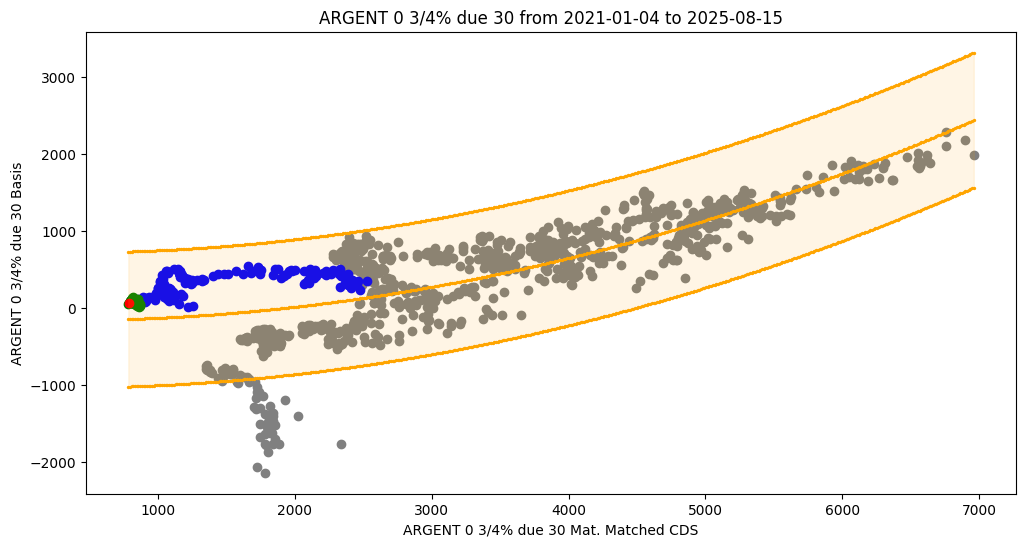

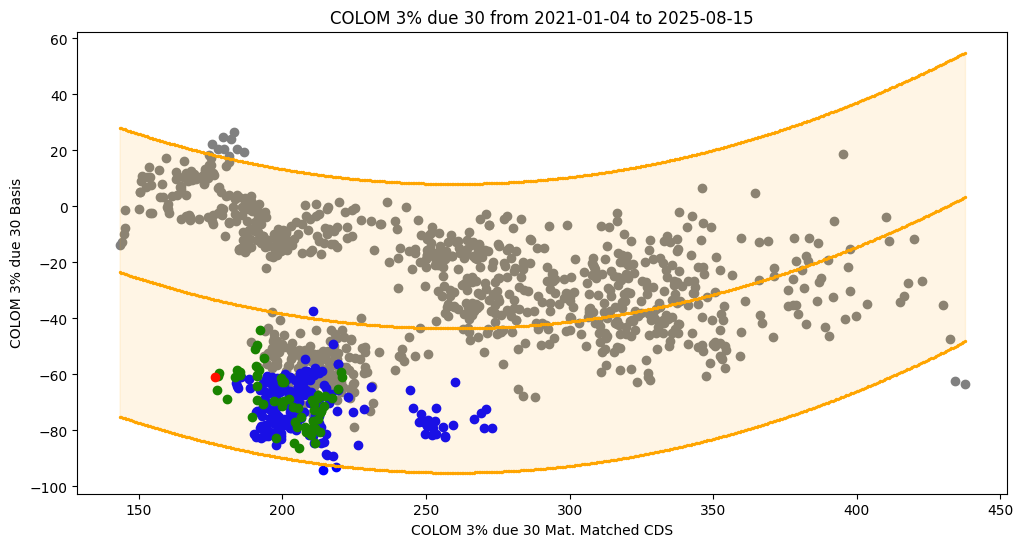

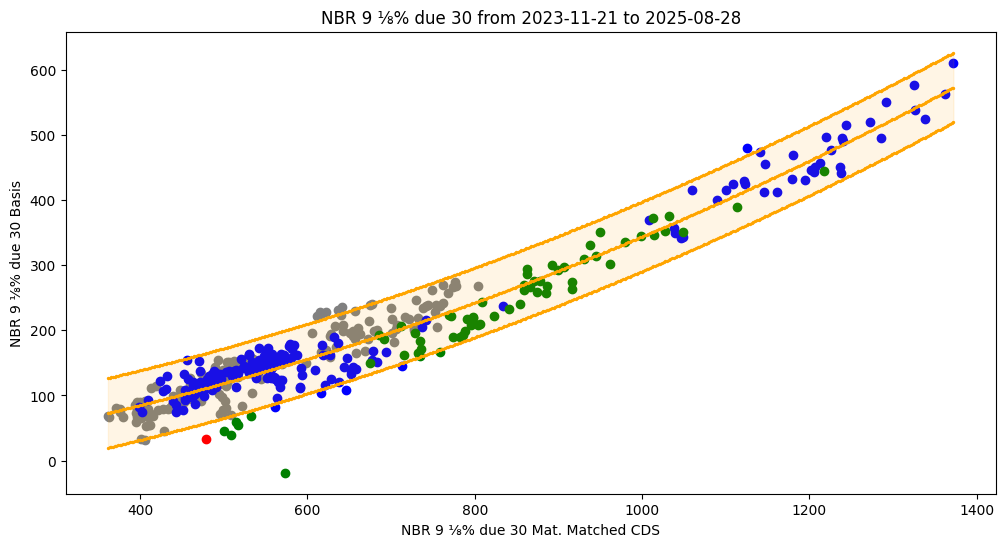

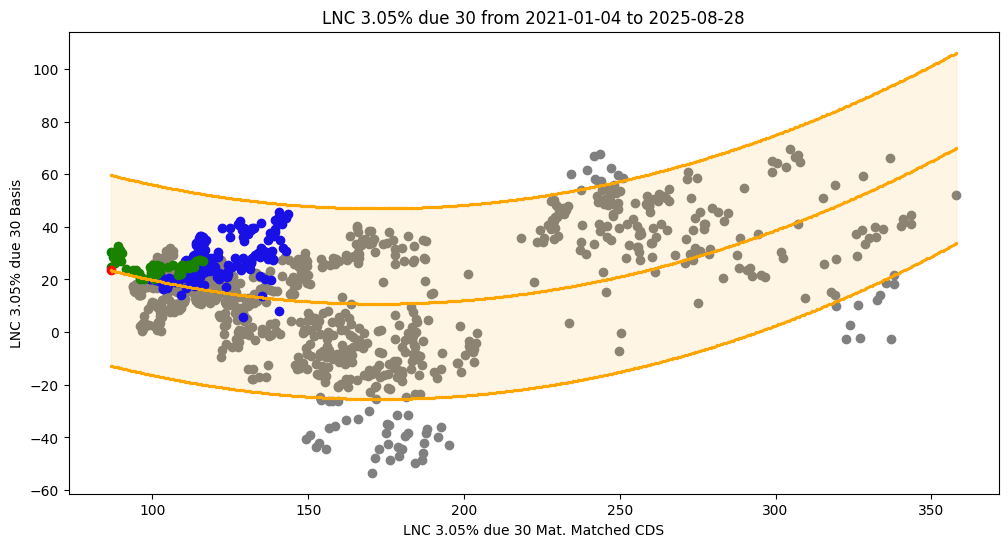

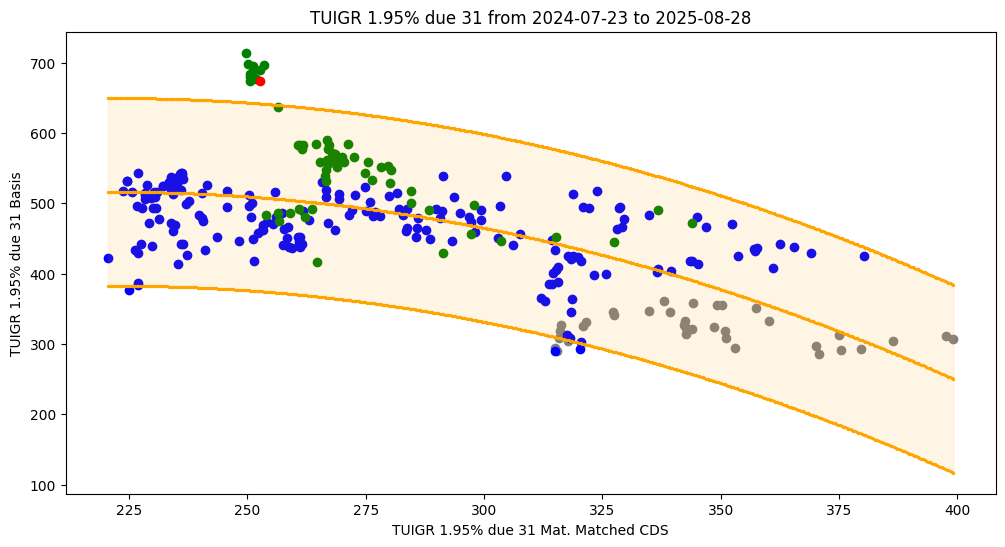

In [340]:
for fam in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    x = plot_names[plot_names["Family"]==fam].copy()
    if len(x)>0:
        for item in x.index:
            bond_name = item + " " + default_bonds[item]
            f = all_bonds[[f"{bond_name} Mat. Matched CDS",f"{bond_name} Basis"]].dropna().copy()
            f = f[f.index>pd.to_datetime("2021-01-01")]
            plt.figure(figsize=(12,6))
            plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[:-252], f[f"{bond_name} Basis"].iloc[:-252], color="gray")
            plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-252:-63], f[f"{bond_name} Basis"].iloc[-252:-63], color="blue")
            plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-63:-1], f[f"{bond_name} Basis"].iloc[-63:-1], color="green")
            plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-1], f[f"{bond_name} Basis"].iloc[-1], color="red")          
            # x = list(f[f"{bond_name} Mat. Matched CDS"])
            # x2 = [item**2 for item in x]
            # X = np.column_stack([x,x2])
            # Y = list(f[f"{bond_name} Basis"])
            # model = sm.OLS(Y, sm.add_constant(X)).fit()
            
            x_scatter = f[f"{bond_name} Mat. Matched CDS"]
            y_scatter = f[f"{bond_name} Basis"]

            coeffs = np.polyfit(x_scatter,y_scatter,2)
            polynomial = np.poly1d(coeffs)
            x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
            y_poly=polynomial(x_poly)
            y_pred = polynomial(x_scatter)
            r2=r2_score(y_scatter,y_pred)
            equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"

            residuals = y_scatter-y_pred
            res_sum=np.sum(residuals**2)
            dof=len(x_scatter)-len(coeffs)
            res_var = res_sum / dof
            se = np.sqrt(res_var)
            conf_upper = y_poly + 2 * se
            conf_lower = y_poly - 2 * se
            
            plt.scatter(x_poly, y_poly,color="orange",s=2)
            plt.scatter(x_poly, conf_upper,color="orange",s=2)
            plt.scatter(x_poly, conf_lower,color="orange",s=2)
            
            plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)

            plt.title(f"{bond_name} from {f.index[0].date()} to {f.index[-1].date()}")
            plt.ylabel(f"{bond_name} Basis")
            plt.xlabel(f"{bond_name} Mat. Matched CDS")
            plt.show()

In [150]:
import os
import win32com.client
import glob
import pandas as pd
import dataframe_image as dfi
from io import BytesIO
import tempfile

html_body = "<html><body>"

outlook = win32com.client.Dispatch("Outlook.Application")
mail = outlook.CreateItem(0)

folder_path = f'J:\\53A. HY Bonds Basis Email\\Email Plots'

for family in ["EM","HY","IG","EURHY", 'EURIG', 'SNRFIN', 'SUBFIN']:
    html_body += f'<h2 style="color:red;">{family}</h2>'
    
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
    png_files = [item for item in png_files if item.rsplit("\\")[-1].split("_")[0]==family]
    png_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].rsplit("_")[-1]))
    
    for png_file in png_files:
        raw_name = os.path.splitext(os.path.basename(png_file))[0]
        image_cid = raw_name.replace(" ", "_")
        attachment = mail.Attachments.Add(Source=png_file)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", image_cid)
        html_body += f'<img src="cid:{image_cid}"><br><br><br>'
    
html_body += '</body></html>'

mail.HTMLBody = html_body
mail.Subject = f'Median Basis ZScores (auto)'
mail.CC = 'vasu.sharma@iiicm.com'
# mail.To = 'spyros.michas@iiicm.com'
mail.Send()

print("Sent")


Sent
